# Dynamic interventions and probabilities of causation in a Bayesian Holling-Tanner fishery model

**Table of contents**<a id='toc0_'></a>    
- [Setup](#toc1_)    
- [Fishery model](#toc2_)    
  - [Trajectories under full fishing/no fishing regimes](#toc2_1_)    
  - [Incorporate uncertainty about model parameters](#toc2_2_)    
- [Probabilities of causation](#toc3_)    
- [Time-of-event interventions](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Motivations and setup

Continuous-time dynamical systems are powerful tools for modeling real-world mechanisms. While users of dynamical systems do not always employ expressly causal language, they often ask ``what-if'' and causal attribution questions of their models. These can range, for example, from contrastive queries about system behavior under different control policies, to sensitivity analyses designed to aid in understanding which parameters drive system variation. In parallel, the causal inference research community has built an expressive taxonomy of causal questions that should directly support and dramatically expand the kinds of queries available to users of continuous-time systems. Significant gaps remain, however, in the technical capacity of the causal inference machinery to operate on continuous-time dynamical systems and, therefore, also  in the breadth of causal queries that can be asked of such systems. This in an illustration of a step towards closing this gap. 

In CITE OUR PAPER we characterize and demonstrate a counterfactual semantics for a class of **state-dependent**, instantaneous interventions that underpin many closed-loop control problems. IN this notebook we provide code for the examples involving the probabilities of causality in a well-established fishery model.

To illustrate a more sophisticated application of our interventional semantics to complex causal estimands, we map the standard definitions for the probability of necessary and sufficient causation onto twin hybrid systems. Importantly, this exercises our semantics on queries concerning "causes of effects," which differ from "effects of causes" queries. Generally speaking, problems in control theory are often most qualitatively similar to the "effects of causes" setting. Optimization in a control problem seeks a control policy (which can be considered a type of cause) that yields the desired effect, but the more explanatory angle of **why** that policy is desirable is most often relegated to sensitivity analyses. We would like to suggest that progress can be made by drawing stronger connections between control theory and causal reasoning tools. On one hand, the control theory community has so far underutilized the extensive toolbox for ``causes of effects'' queries, and, on the other, the causality community is still developing its capacity to utilize the expressive model classes studied in control theory. We aim to take a step towards closing this gap.

Notions of causal necessity and sufficiency are often productively employed in policy discourse, especially where competing interests require human-understandable justifications as to whether a particular policy is sufficient and/or necessary to achieve desired outcomes. In modern resource management, for example, tragedies of the commons frequently demand a challenging balance between ecological objectives and short and long-term economic outcomes. Additionally, such cases often involve models that our interventional semantics is designed to operate on.

Fishery management offers a particularly rich set of problems where ``causes of effects'' queries on dynamical systems models can help streamline policy discourse. Over the last few decades, numerous fishery management crises have followed a similar arc: first, growing markets and new technologies result in overfishing to unsustainable biomass levels; then, regulators impose strict catch quotas, gear restrictions, data collection requirements, area closures, and other measures designed to allow stocks to rebuild; after rebuilding stocks, fishing resumes, ideally at more sustainable levels. In \citeyear{groundfish-emergency-2000}, for example, the NMFS and NOAA\footnote{That is, National Marine Fisheries Service and National Oceanic and Atmospheric Administration.} announced emergency regulatory measures in response to the failure of the Pacific coast groundfish fishery \citep{groundfish-emergency-2000}. This was followed by an economically tumultuous rebuilding period of around 10 years \citep{warlick-groundfish-history-2018}, after which fishing restrictions changed and loosened \citep{groundfish-trawl-rationalization-2010}. Similarly, the 1990s saw significant declines in the Atlantic swordfish fishery \citep{neilson-2013-swordfish-recovery}. In 2000, the ICCAT\footnote{That is, International Commission for the Conservation of Atlantic Tunas.} established an ultimately successful 10-year plan to rebuild the stock \citep{neilson-2013-swordfish-recovery,swordfish-report-2010}.

Naturally, these measures were not without significant economic consequences and backlash, both short and long term \citep{groundfish-emergency-2000,cramer_graying_2018,swordfish-measures-2007-comments}. Indeed, in the United States, the Magnuson-Stevens Act (MSA) mandates the multi-objective of avoiding unnecessary economic sacrifice while pursuing long-term economic and ecological outcomes \citep{magnusen-stevens-1976,anon_sustainable_1996,magnuson-stevens-reauth-2007,anon_modernizing_2018}. Myriad ecological and bio-economic dynamical systems approaches were developed during and after these crises to better balance competing objectives \citep{lee-2000-bioeconomic-swordfish,ortiz-2009-tuna-sim,restrepol-mcmc-fishparams-2011,taylor_preliminary_2022}. On some occasions, post-mortems were employed to, for example, determine the degree to which rebuilding success was due to management actions or to natural factors such as species biology \cite{neilson-2013-swordfish-recovery}. In essence, the goal of such efforts, as stated in the MSA, is to identify and implement sufficient rebuilding measures that would induce no more economic hardship than necessary.

We now aim to demonstrate how our proposed causal semantics can support such efforts.


In [50]:
#from load import load 
import os
import pickle
from collections import OrderedDict
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive

from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.dynamical.handlers import (
    DynamicIntervention,
    LogTrajectory,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.internals._utils import _unsqueeze_time_dim, append
from chirho.dynamical.ops import State, simulate
from chirho.interventional.handlers import do

smoke_test = "CI" in os.environ


num_samples = 100 if not smoke_test else 30
num_steps = 300 if not smoke_test else 10
epochs = 300 if not smoke_test else 10


from datetime import datetime, timedelta

import matplotlib.patches as mpatches
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class LogTrajectoryAndInterventionTime(LogTrajectory):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.recorded_interruption_time = False
    def _pyro_post_simulate_to_interruption(self, msg):
        if not self.recorded_interruption_time:
            self.recorded_interruption_time = True
            self.interruption_time = msg['value'][1]
            self.interruption_state = msg['value'][0]
            if self.is_traced:       
                pyro.deterministic("interruption_time", msg['value'][1])
                for key in self.interruption_state.keys():
                    pyro.deterministic(f"interruption_state_{key}", msg['value'][0][key])
                

## <a id='toc2_'></a>[Fishery model](#toc0_)

/tmp/ipykernel_212710/204886567.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


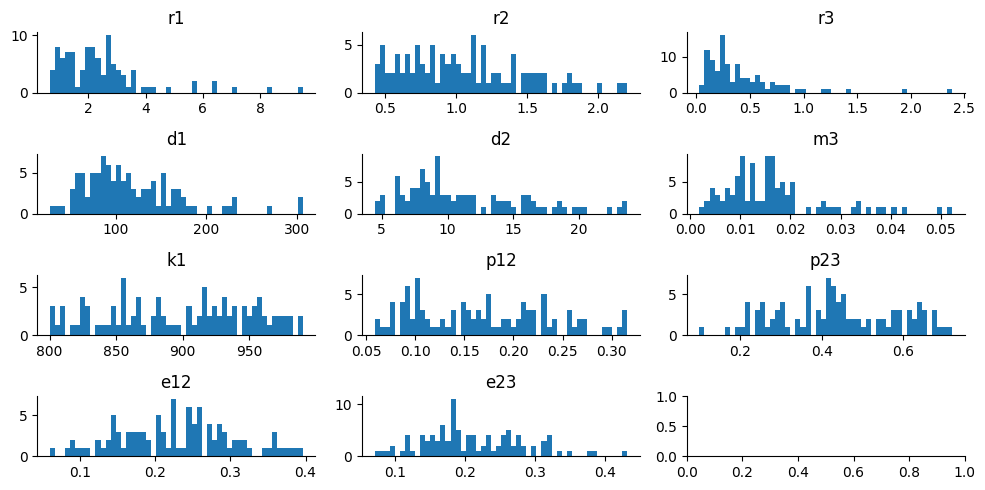

In [3]:
loc_scale_for_prior = OrderedDict(
    r1=dict(loc=0.76, scale=0.59),
    r2=dict(loc=0.0, scale=0.42),
    r3=dict(loc=-1.3, scale=0.79),
    d1=dict(loc=4.61, scale=0.42),
    d2=dict(loc=2.30, scale=0.42),
    m3=dict(loc=-4.232, scale=0.6)
)

def sample_fishery_priors():
    sampled =  {
        key: pyro.sample(key, dist.LogNormal(value["loc"], value["scale"]))
        for key, value in loc_scale_for_prior.items()
    }

    sampled['k1'] = pyro.sample('k1', dist.Uniform(800, 1000.))
    sampled['p12'] = pyro.sample('p12', dist.Beta(3., 6.))/2
    sampled['p23'] = pyro.sample('p23', dist.Beta(4., 5.))
    sampled['e12'] = pyro.sample('e12', dist.Beta(5., 6.))/2
    sampled['e23'] = pyro.sample('e23', dist.Beta(5., 6.))/2

    return sampled

with pyro.plate("prior", num_samples):
    param_samples = sample_fishery_priors()


fig, ax = plt.subplots(4, 3, figsize=(10, 5))
ax = ax.flatten()

i = 0 
for key, value in param_samples.items():
    ax[i].hist(value.detach().numpy(), bins=50)
    ax[i].set_title(key)
    i += 1
   
sns.despine()
fig.tight_layout()
fig.show()

In [4]:
param_sample_medians = {
    key: value.median()
    for key, value in param_samples.items()
}

INITIAL_STATE_no_pressure = {
    "forage": torch.tensor(1000),
    "intermediate": torch.tensor(150),
    "apex": torch.tensor(30),
    'catch_intermediate': torch.tensor(0.0),
    'fishing_effort_forage': torch.tensor(0.0),
    'fishing_effort_intermediate': torch.tensor(0),
    'fishing_effort_apex': torch.tensor(0.0),
}



INITIAL_STATE_pressure = {
    "forage": torch.tensor(1000),
    "intermediate": torch.tensor(150),
    "apex": torch.tensor(30),
    'catch_intermediate': torch.tensor(0.0),
    'fishing_effort_forage': torch.tensor(0.0),
    'fishing_effort_intermediate': torch.tensor(0.7),
    'fishing_effort_apex': torch.tensor(0.07),
}

def add_postfix_to_dict(d, postfix):
    return {f"{k}_{postfix}": v for k, v in d.items()}

INITIAL_STATE_NO_PRESSURE = add_postfix_to_dict(INITIAL_STATE_no_pressure, "no_pressure")
INITIAL_STATE_PRESSURE = add_postfix_to_dict(INITIAL_STATE_pressure, "pressure")
INITIAL_STATE_DEPENDENT = add_postfix_to_dict(INITIAL_STATE_pressure, "dependent")
INITIAL_STATE_STATIC = add_postfix_to_dict(INITIAL_STATE_pressure, "static")

In [ ]:
class FishDynamics(pyro.nn.PyroModule):
    def __init__(self, params: Dict = param_sample_medians, postfix: str = ""):
        super().__init__()
        self.params = params
        self.postfix = postfix
    

    @staticmethod
    def holling_tanner(B: torch.Tensor, r: torch.Tensor, K: torch.Tensor, 
                    M: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        The general holling-tanner differential equation.
        This subtracts predator and fishing mortality from capacity-limited growth.
        B is the biomass for this trophic level.
        K is its carrying capacity, which may be a function of prey biomass.
        M is the mortality rate, potentially due to predation.
        F is the fishing mortality rate.
        """
        return r * B * (1 - B / K) - M * B - F * B

    @staticmethod
    def mortality_from_predation(B: torch.Tensor, B_pred: torch.Tensor, 
                                p: torch.Tensor, D: torch.Tensor) -> torch.Tensor:
        """
        Mortality rate of prey due to predation.
        This plugs in as M above for prey species with biomass B.
        p is the maximum rate of predation.
        B is the biomass of the prey, and B_pred is the biomass of the predator.
        D is the biomass when the predation rate reaches half of its maximum.
        """
        return (p * B_pred) / (D + B)

    @staticmethod
    def carrying_capacity_of_predator(B_prey: torch.Tensor, e: torch.Tensor) -> torch.Tensor:
        """
        Carrying capacity of the predator — this plugs in as K above for predator species.
        e is the proportion of prey biomass that is converted into predator biomass.
        """
        return B_prey * e

    @staticmethod
    def intermediate_trophic_level(B: torch.Tensor, r: torch.Tensor, B_prey: torch.Tensor, 
                                e: torch.Tensor, B_pred: torch.Tensor, p: torch.Tensor, 
                                D: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        Equation for intermediate trophic levels that are both prey and predator.
        """
        K = FishDynamics.carrying_capacity_of_predator(B_prey, e)
        M = FishDynamics.mortality_from_predation(B, B_pred, p, D)
        return FishDynamics.holling_tanner(B, r, K, M, F)

    @staticmethod
    def apex_trophic_level(B: torch.Tensor, r: torch.Tensor, B_prey: torch.Tensor, 
                        e: torch.Tensor, M: torch.Tensor, F: torch.Tensor) -> torch.Tensor:
        """
        The top trophic level that has some constant natural mortality rate.
        """
        
        K = FishDynamics.carrying_capacity_of_predator(B_prey, e)
       
        return FishDynamics.holling_tanner(B, r, K, M, F)

    @staticmethod
    def forage_trophic_level(B: torch.Tensor, r: torch.Tensor, K: torch.Tensor, 
                            B_pred: torch.Tensor, p: torch.Tensor, D: torch.Tensor, 
                            F: torch.Tensor) -> torch.Tensor:
        """
        The bottom trophic level that has some constant carrying capacity
        """

        M = FishDynamics.mortality_from_predation(B, B_pred, p, D)
        return FishDynamics.holling_tanner(B, r, K, M, F)

    def forward(self, X: State[torch.Tensor]) -> State[torch.Tensor]:
        r1, r2, r3, d1, d2, m3, k1, p12, p23, e12, e23 = self.params.values()
        postfix = self.postfix  
  
        dX = dict()
        dX[f"forage_{postfix}"] = FishDynamics.forage_trophic_level(
            X[f"forage_{postfix}"], r1, k1, X[f"intermediate_{postfix}"], p12, d1, X[f"fishing_effort_forage_{postfix}"]
        )


        dX[f"intermediate_{postfix}"] = FishDynamics.intermediate_trophic_level(
            B = X[f"intermediate_{postfix}"], 
            r = r2, 
            B_prey = X[f"forage_{postfix}"],
            e =  e12,
            B_pred = X[f"apex_{postfix}"],
            p =  p23, 
            D = d2,
            F = X[f"fishing_effort_intermediate_{postfix}"]
        )


        dX[f"apex_{postfix}"] = FishDynamics.apex_trophic_level(
            B = X[f"apex_{postfix}"], 
            r = r3, 
            B_prey = X[f"intermediate_{postfix}"],
            e = e23, 
            M = m3, 
            F = X[f"fishing_effort_apex_{postfix}"]
        )

        dX[f'catch_intermediate_{postfix}'] = X[f'fishing_effort_intermediate_{postfix}'] * X[f'intermediate_{postfix}']
     

        dX[f'fishing_effort_forage_{postfix}'] = torch.zeros_like(X[f'fishing_effort_forage_{postfix}'])
        dX[f'fishing_effort_intermediate_{postfix}'] = torch.zeros_like(X[f'fishing_effort_intermediate_{postfix}'])
        dX[f'fishing_effort_apex_{postfix}'] = torch.zeros_like(X[f'fishing_effort_apex_{postfix}'])

        return(dX)

### <a id='toc2_1_'></a>[Trajectories under full fishing/no fishing regimes](#toc0_)

In [6]:
def plot_trajectories(trajectories, title, logging_times, ylim=None):
    fig, ax = plt.subplots(7, 1, figsize=(15, 15))

    #xticks = np.arange(np.min(logging_times), np.max(logging_times) + 1/12, 1/12)
    
    x_ticks = torch.arange(logging_times.min(), logging_times.max(), 1/12)
    for i, key in enumerate(trajectories.keys()):
        ax[i].plot(logging_times, trajectories[key], label=key)
        ax[i].set_title(key)
        ax[i].set_xlabel("month")
        ax[i].set_xticks(x_ticks)
        ax[i].set_xticklabels([])

        if ylim is not None:
            ax[i].set_ylim(ylim)
        

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine()
    plt.suptitle(title)
    plt.show()

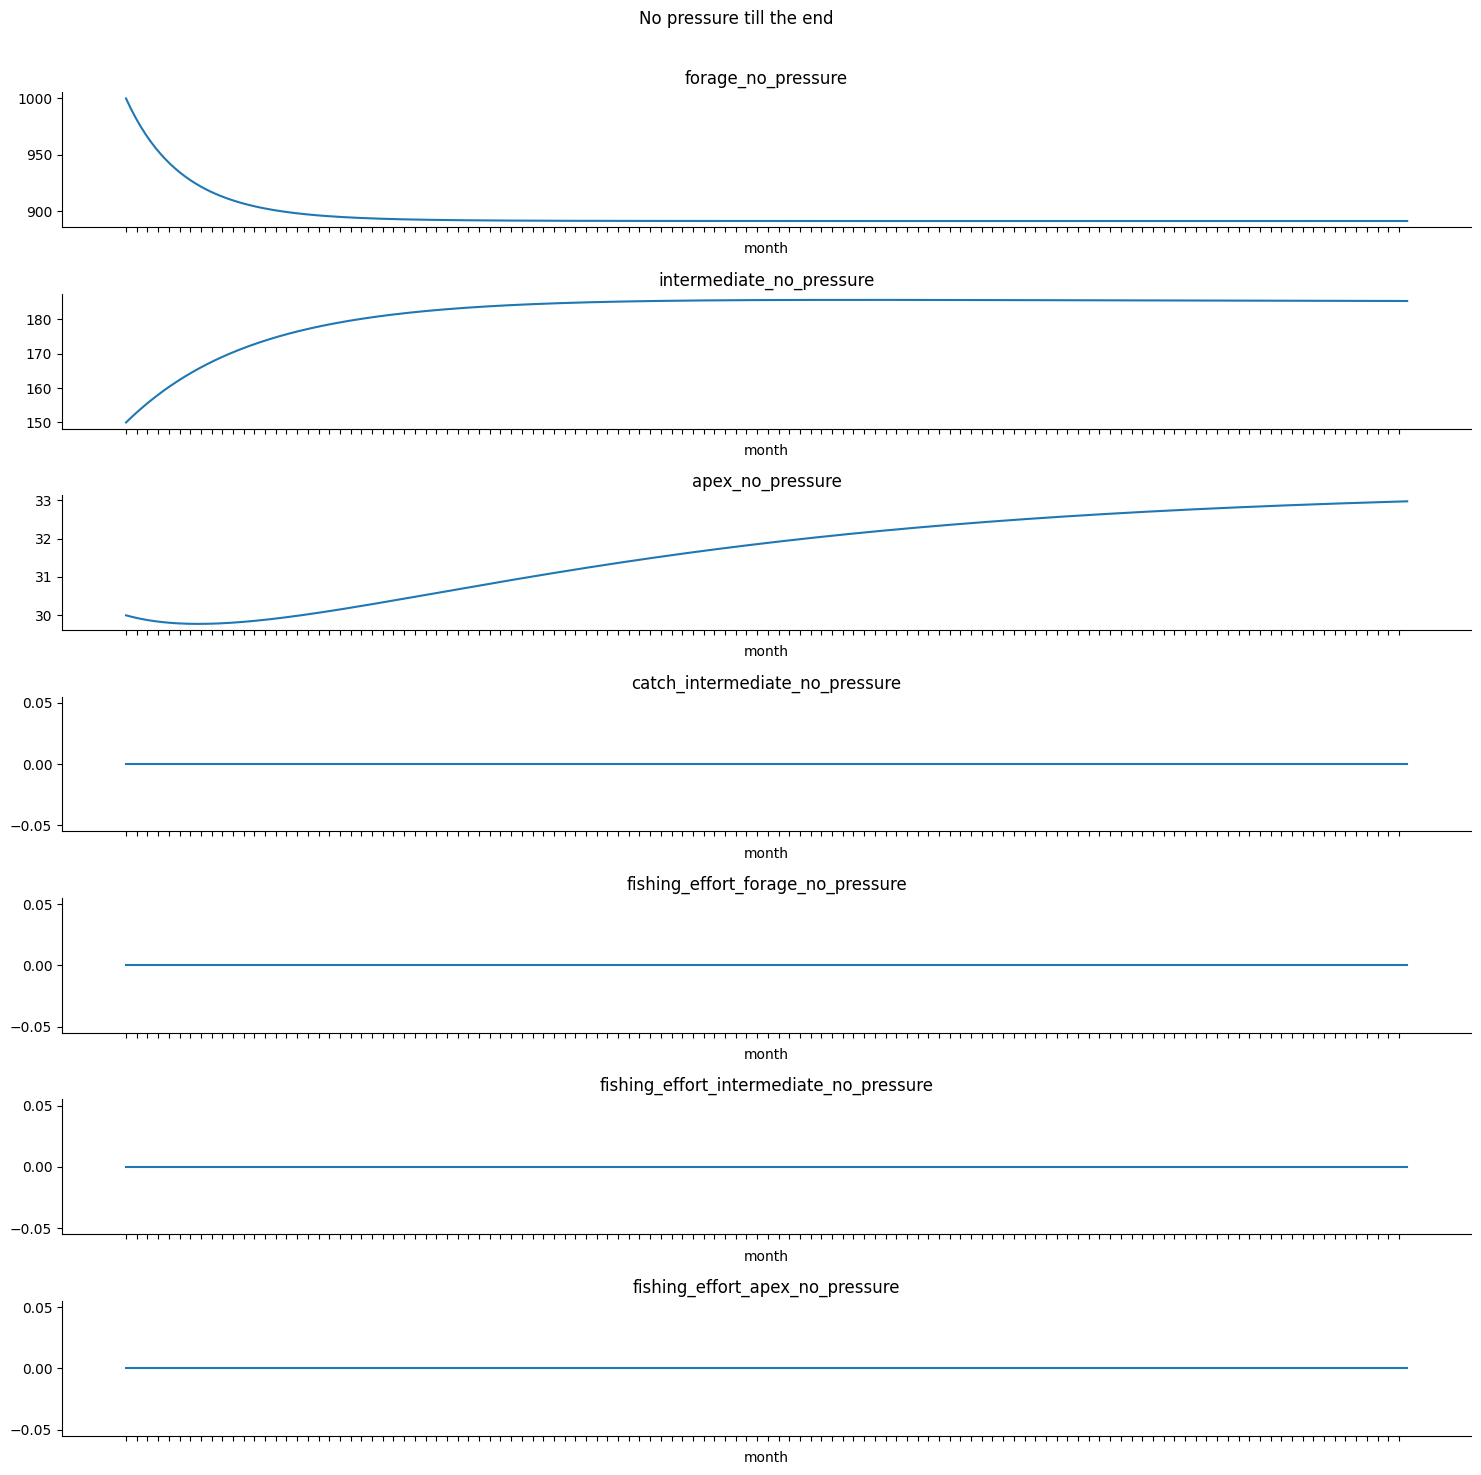

In [7]:
fish_dynamics_pressure = FishDynamics(postfix = "pressure")
fish_dynamics_no_pressure = FishDynamics(postfix = "no_pressure")

start_time = torch.tensor(0.0)
end_time = torch.tensor(1)
end_of_the_world = torch.tensor(10.)
step_size = torch.tensor(1/52)
logging_times = torch.arange(start_time, end_time, step_size)
end_of_the_world_logging_times = torch.arange(start_time, end_of_the_world, step_size)


with TorchDiffEq(), LogTrajectory(end_of_the_world_logging_times) as lt_end:
    simulate(fish_dynamics_no_pressure, INITIAL_STATE_NO_PRESSURE, start_time, end_of_the_world,)

trajectory_end = lt_end.trajectory

plot_trajectories(trajectory_end, "No pressure till the end", end_of_the_world_logging_times)

In [8]:
trajectory_end.keys()

stable_initial_biomass = {
    "forage": trajectory_end['forage_no_pressure'][-1],
    "intermediate": trajectory_end['intermediate_no_pressure'][-1],
    "apex": trajectory_end['apex_no_pressure'][-1],
}

print(stable_initial_biomass)

{'forage': tensor(891.1979), 'intermediate': tensor(185.3568), 'apex': tensor(32.9739)}


In [9]:
def update_init_with_equilibrium(init: Dict):
    for  key_stable in stable_initial_biomass:
        for key in init.keys():
            if key.startswith(key_stable):
                init[key] = stable_initial_biomass[key_stable]

    return init

# update to median-based 10 year near-equilibrium biomass states
INITIAL_STATE_NO_PRESSURE = update_init_with_equilibrium(INITIAL_STATE_NO_PRESSURE)
INITIAL_STATE_PRESSURE = update_init_with_equilibrium(INITIAL_STATE_PRESSURE)
INITIAL_STATE_DEPENDENT = update_init_with_equilibrium(INITIAL_STATE_DEPENDENT)
INITIAL_STATE_STATIC = update_init_with_equilibrium(INITIAL_STATE_STATIC)

In [10]:
with TorchDiffEq(), LogTrajectory(logging_times) as lt_no_pressure:
    simulate(fish_dynamics_no_pressure, INITIAL_STATE_NO_PRESSURE, start_time, end_time,)

trajectory_no_pressure = lt_no_pressure.trajectory

In [11]:
with TorchDiffEq(), LogTrajectory(logging_times) as lt_pressure:
    simulate(fish_dynamics_pressure, INITIAL_STATE_PRESSURE, start_time, end_time)
trajectory_pressure = lt_pressure.trajectory

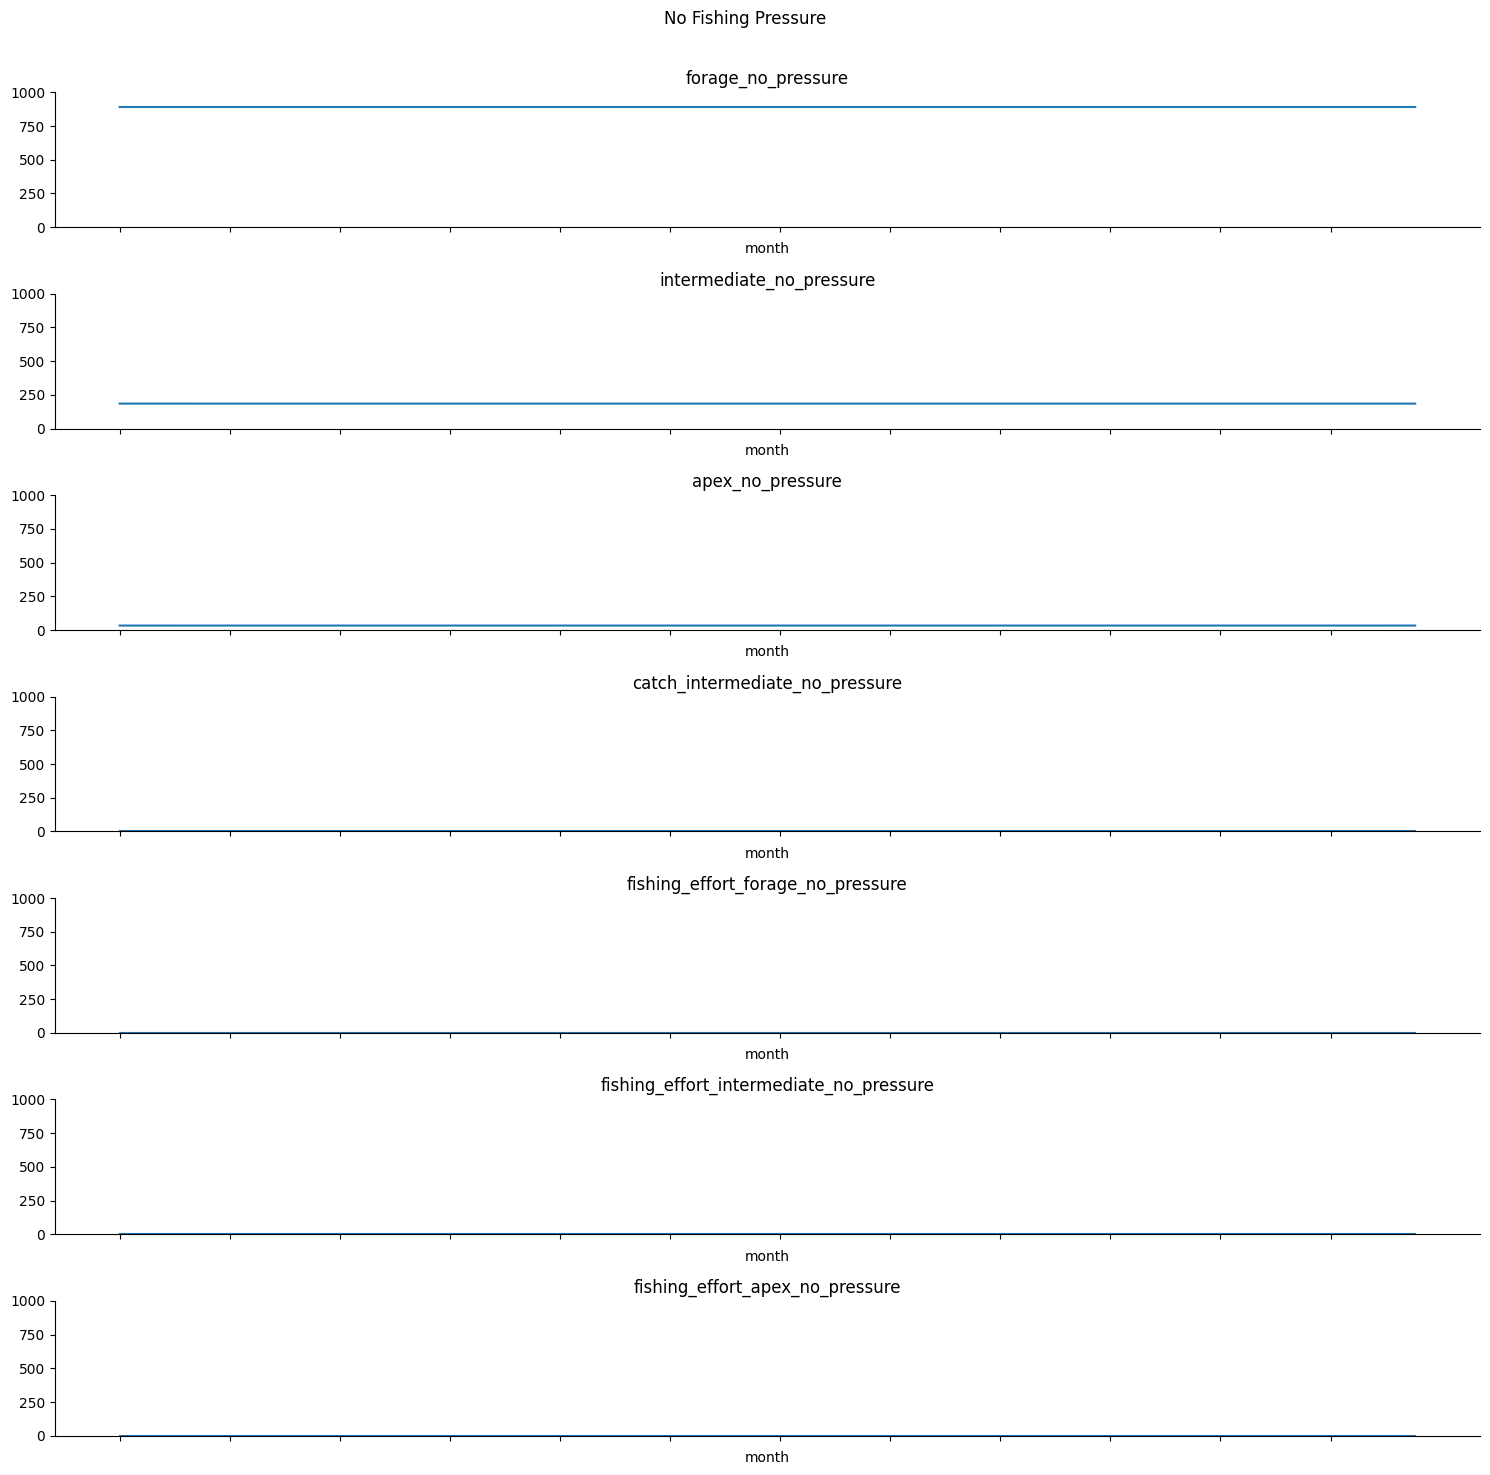

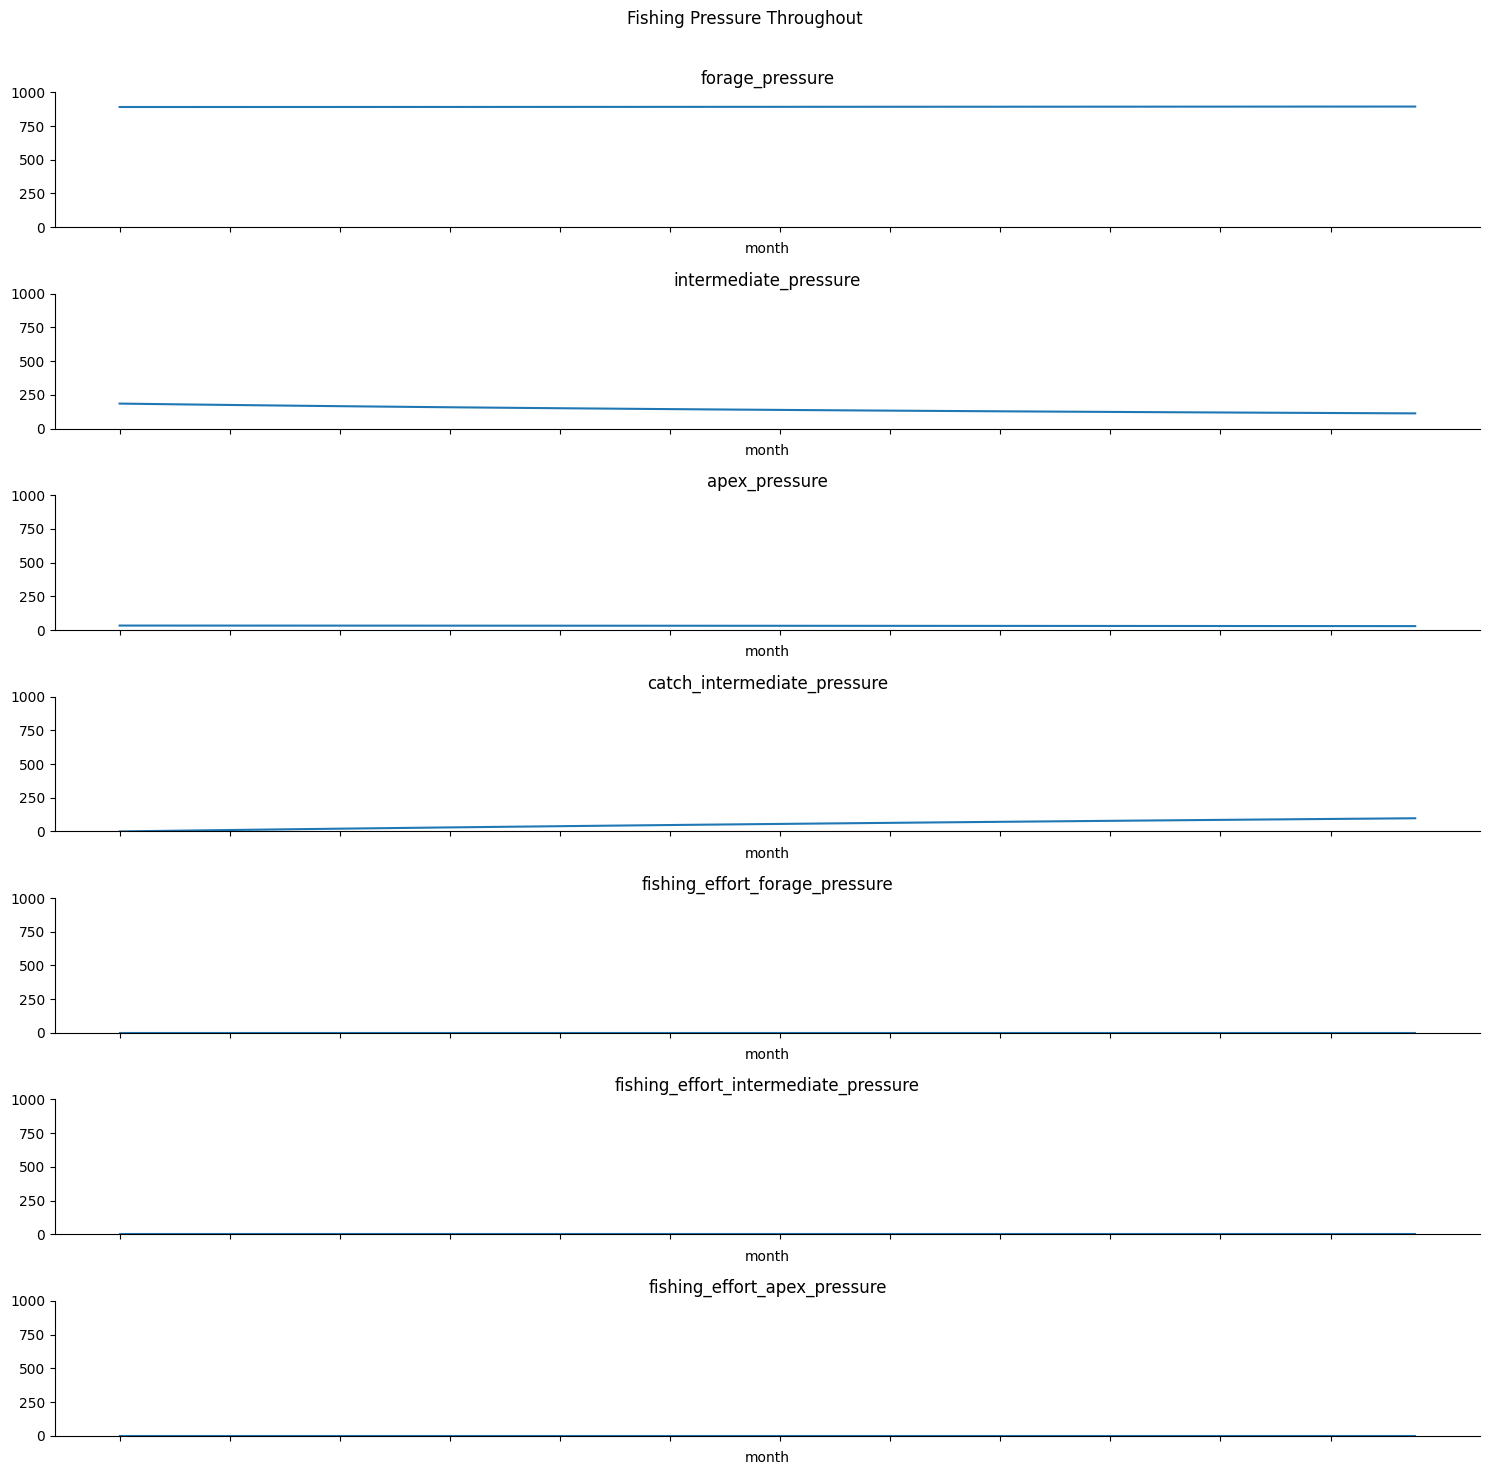

In [ ]:
plot_trajectories(trajectory_no_pressure, "No Fishing Pressure", logging_times=logging_times, ylim = (0, 1000))
plot_trajectories(trajectory_pressure, "Fishing Pressure Throughout", logging_times=logging_times, ylim = (0, 1000))

### <a id='toc2_2_'></a>[Incorporate uncertainty about model parameters](#toc0_)

In [13]:
def stop_fishing_policy(target_state: State[torch.tensor], postfix: str = "dependent"):
    """
    The event function for the stop fishing policy. This is a function
    that passes zero when the catch of the intermediate fish passes a quota
    specified by `target_state`.
    """
    def event_f(t: torch.tensor, state: State[torch.tensor]):
        return  state[f"catch_intermediate_{postfix}"] - target_state[f"catch_intermediate_{postfix}"]
    return event_f

In [14]:
quota = {'catch_intermediate_dependent': torch.tensor(40.)}
season_ends = {key: torch.tensor(0.) for key in INITIAL_STATE_DEPENDENT.keys() if key.startswith('fishing_effort')}

In [15]:
# add uncertainty about initial state
def randomize_init_state(init: Dict, postfix = ""):
    init = init.copy()

    if postfix != "":
        postfix = "_"+postfix
    for key, value in init.items():

        if key.startswith('forage'):
            init[key] = pyro.sample(f"forage_init{postfix}", dist.Uniform(0.95  * init[key], 1.05 * init[key]))
        elif key.startswith('intermediate'):
            init[key] = pyro.sample(f"intermediate_init{postfix}", dist.Uniform(0.95  * init[key], 1.05 * init[key]))
        elif key.startswith('apex'):
            init[key] = pyro.sample(f"apex_init{postfix}", dist.Uniform(0.95  * init[key], 1.05 * init[key]))

    for key, value in init.items():
        if key.startswith('fishing_effort_intermediate') and init[key] != 0:
            init[key] = pyro.sample(f"fishing_effort_intermediate{postfix}", dist.Normal(init[key], init[key] * .1)).clamp(0.001, 0.999)
        elif key.startswith('fishing_effort_apex') and init[key] != 0:
            init[key] = pyro.sample(f"fishing_effort_apex{postfix}", dist.Normal(init[key], init[key] * .1)).clamp(0.001, 0.999)

    return init



def copy_init_state_values(source: Dict, target, postfix: str, copy_pressure = False):
    init = target.copy()
    for key in source.keys():
        if key.startswith("forage"):
            init[f"forage_{postfix}"] = source[key]
        elif key.startswith('intermediate'):
            init[f"intermediate_{postfix}"] =  source[key]
        elif key.startswith('apex'):
            init[f"apex_{postfix}"] = source[key]

    if copy_pressure:
        for key in source.keys():
            if key.startswith('fishing_effort_intermediate'):
                init[f"fishing_effort_intermediate_{postfix}"] = source[key]
            elif key.startswith('fishing_effort_apex'):
                init[f"fishing_effort_apex_{postfix}"] = source[key]

    return init

In [16]:
class LogTrajectoryPostfix(LogTrajectory):
    def __init__(self, times: torch.Tensor, is_traced: bool = False, postfix: str = ""):
        super().__init__(times, is_traced)
        self.postfix = postfix

    def _pyro_post_simulate(self, msg: dict) -> None:
        initial_state: State[T] = msg["args"][1]
        start_time = msg["args"][2]

        if start_time == self.times[0]:

            self._trajectory: State[T] = append(
                _unsqueeze_time_dim(initial_state), self._trajectory
            )

        self.trajectory: State[T] = self._trajectory
        self._trajectory: State[T] = type(initial_state)()

        if self.is_traced:
            [pyro.deterministic(f"{name}_{self.postfix}", value) for name, value in self.trajectory.items()]

In [17]:
print(randomize_init_state(INITIAL_STATE_DEPENDENT))

{'forage_dependent': tensor(932.3353), 'intermediate_dependent': tensor(191.4483), 'apex_dependent': tensor(33.8842), 'catch_intermediate_dependent': tensor(0.), 'fishing_effort_forage_dependent': tensor(0.), 'fishing_effort_intermediate_dependent': tensor(0.6613), 'fishing_effort_apex_dependent': tensor(0.0832)}


In [18]:
FRESH_RUN = False

pyro.clear_param_store()
torch.manual_seed(42)
pyro.set_rng_seed(42)
quota_list = [float(x) for x in range(0, 121, 5)]

# WARNING: this is cached to avoid repeated long runs
# cache to avoid repeated long runs
fishery_samples_path = "fishery_samples.pkl"
if os.path.exists(fishery_samples_path) and not FRESH_RUN:
    print("Loading cached fishery samples")
    with open(fishery_samples_path, "rb") as f:
        fishery_samples = pickle.load(f)
else:
    print(f"Running fishery sampling.")



    #quota_list = [120]

    def bayesian_parallel_dynamics():

        shared_noise = sample_fishery_priors()

        # the initial state biomass noise is also shared

        INITIAL_STATE_DEPENDENT_sample = randomize_init_state(INITIAL_STATE_DEPENDENT, "dependent")

        INITIAL_STATE_NO_PRESSURE_sample = copy_init_state_values(source = INITIAL_STATE_DEPENDENT_sample,
        target = INITIAL_STATE_NO_PRESSURE, postfix = "no_pressure")

        INITIAL_STATE_PRESSURE_sample =  copy_init_state_values(source = INITIAL_STATE_DEPENDENT_sample,
        target = INITIAL_STATE_PRESSURE, postfix = "pressure", copy_pressure = True)



        # INITIAL_STATE_NO_PRESSURE_sample = randomize_init_state(INITIAL_STATE_NO_PRESSURE,)
        # INITIAL_STATE_PRESSURE_sample =  copy_init_state_values(source = INITIAL_STATE_NO_PRESSURE_sample,
        # target = INITIAL_STATE_PRESSURE, postfix = "pressure")

        # #INITIAL_STATE_DEPENDENT_sample = copy_init_state_values(source = INITIAL_STATE_NO_PRESSURE_sample,
        # #target = INITIAL_STATE_DEPENDENT, postfix = "dependent")

        # INITIAL_STATE_STATIC_sample = copy_init_state_values(source = INITIAL_STATE_NO_PRESSURE_sample,
        # target = INITIAL_STATE_STATIC, postfix = "static")



        fish_dynamics_no_pressure = FishDynamics(params = shared_noise, postfix = "no_pressure")
        fish_dynamics_pressure = FishDynamics(params = shared_noise, postfix = "pressure")
        fish_dynamics_state_dependent = FishDynamics(params = shared_noise, postfix = "dependent")

    

        with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True):
            simulate(fish_dynamics_no_pressure, INITIAL_STATE_NO_PRESSURE_sample, start_time, end_time,)

        with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True):
            simulate(fish_dynamics_pressure, INITIAL_STATE_PRESSURE_sample, start_time, end_time)

        
        for quota_limit in [torch.tensor(k) for k in quota_list]:

            quota = {'catch_intermediate_dependent': quota_limit}
            with TorchDiffEq(),LogTrajectoryPostfix(logging_times, is_traced=True, postfix = str(quota_limit.item())):
                with DynamicIntervention(event_fn=stop_fishing_policy(quota), intervention= season_ends):
                            simulate(fish_dynamics_state_dependent, INITIAL_STATE_DEPENDENT_sample, start_time, logging_times[-1])
        
    fishery_predictive = Predictive(bayesian_parallel_dynamics, num_samples=100,)
    fishery_samples =  fishery_predictive()

    with open(fishery_samples_path, "wb") as f:
        pickle.dump(fishery_samples, f)

Loading cached fishery samples


In [19]:
pressure_samples = {key: value for key, value in fishery_samples.items() if "pressure" in key and "no" not in key}
no_pressure_samples = {key: value for key, value in fishery_samples.items() if "no_pressure" in key}
dependent_supersamples = {key: value for key, value in fishery_samples.items() if "dependent" in key}

dependent_samples = {}
for q in quota_list:
    dependent_samples[q] = {key: value for key, value in dependent_supersamples.items() if str(q) in key}
    dependent_samples[q].update({key: value for key, value in dependent_supersamples.items() if "init_dependent" in key})

In [20]:
def plot_trajectory_samples(samples, postfix, title, event_time = None, logging_times = logging_times):

    pressure_samples_medians = {key: value.median(dim = 0).values for key, value in samples.items()}
    pressure_samples_lows = {key: value.quantile(0.05, dim = 0) for key, value in samples.items()}
    pressure_samples_highs = {key: value.quantile(0.95, dim = 0) for key, value in samples.items()}
    
    state_keys = [f'forage_{postfix}', f'intermediate_{postfix}', f'apex_{postfix}', f'catch_intermediate_{postfix}']   

    
    fig, ax = plt.subplots(len(state_keys)+1, 1, figsize=(15, 15))
    
    ax = ax.flatten()
    x_ticks = torch.arange(logging_times.min(), logging_times.max(), 1/12)
    

    for i in range(len(state_keys)):
        key = state_keys[i]
        ax[i].plot(logging_times, pressure_samples_medians[key], label=key)
        ax[i].set_title(key)
        ax[i].fill_between(
            logging_times,      
            pressure_samples_lows[key],
            pressure_samples_highs[key],
            alpha=0.2,
        )
        ax[i].set_xticks(x_ticks)
        ax[i].set_xticklabels([])
        ax[i].set_xlabel("month")



        if event_time is not None:
            ax[i].axvline(event_time, color='red', linestyle='--')


    pressure = samples[f'fishing_effort_intermediate_{postfix}']

    average_pressure = False
    if pressure.dim() > 1:
        pressure_low = pressure_samples_lows[f'fishing_effort_intermediate_{postfix}']
        pressure_high = pressure_samples_highs[f'fishing_effort_intermediate_{postfix}']        
        average_pressure = True
        pressure = pressure.median(dim=0).values

    ax[len(state_keys)].plot(logging_times, pressure)
    ax[len(state_keys)].set_title(f'Fishing Effort Intermediate_{postfix}')

    if average_pressure:
        ax[len(state_keys)].fill_between(
            logging_times,
            pressure_low,
            pressure_high,
            alpha=0.2,
        )
    ax[len(state_keys)].set_ylim(-0.1,1)
    ax[len(state_keys)].set_xticks(x_ticks)
    ax[len(state_keys)].set_xticklabels([])
    ax[len(state_keys)].set_xlabel("month")
    


    fig.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine()
    fig.suptitle(title)
    
    return fig, ax


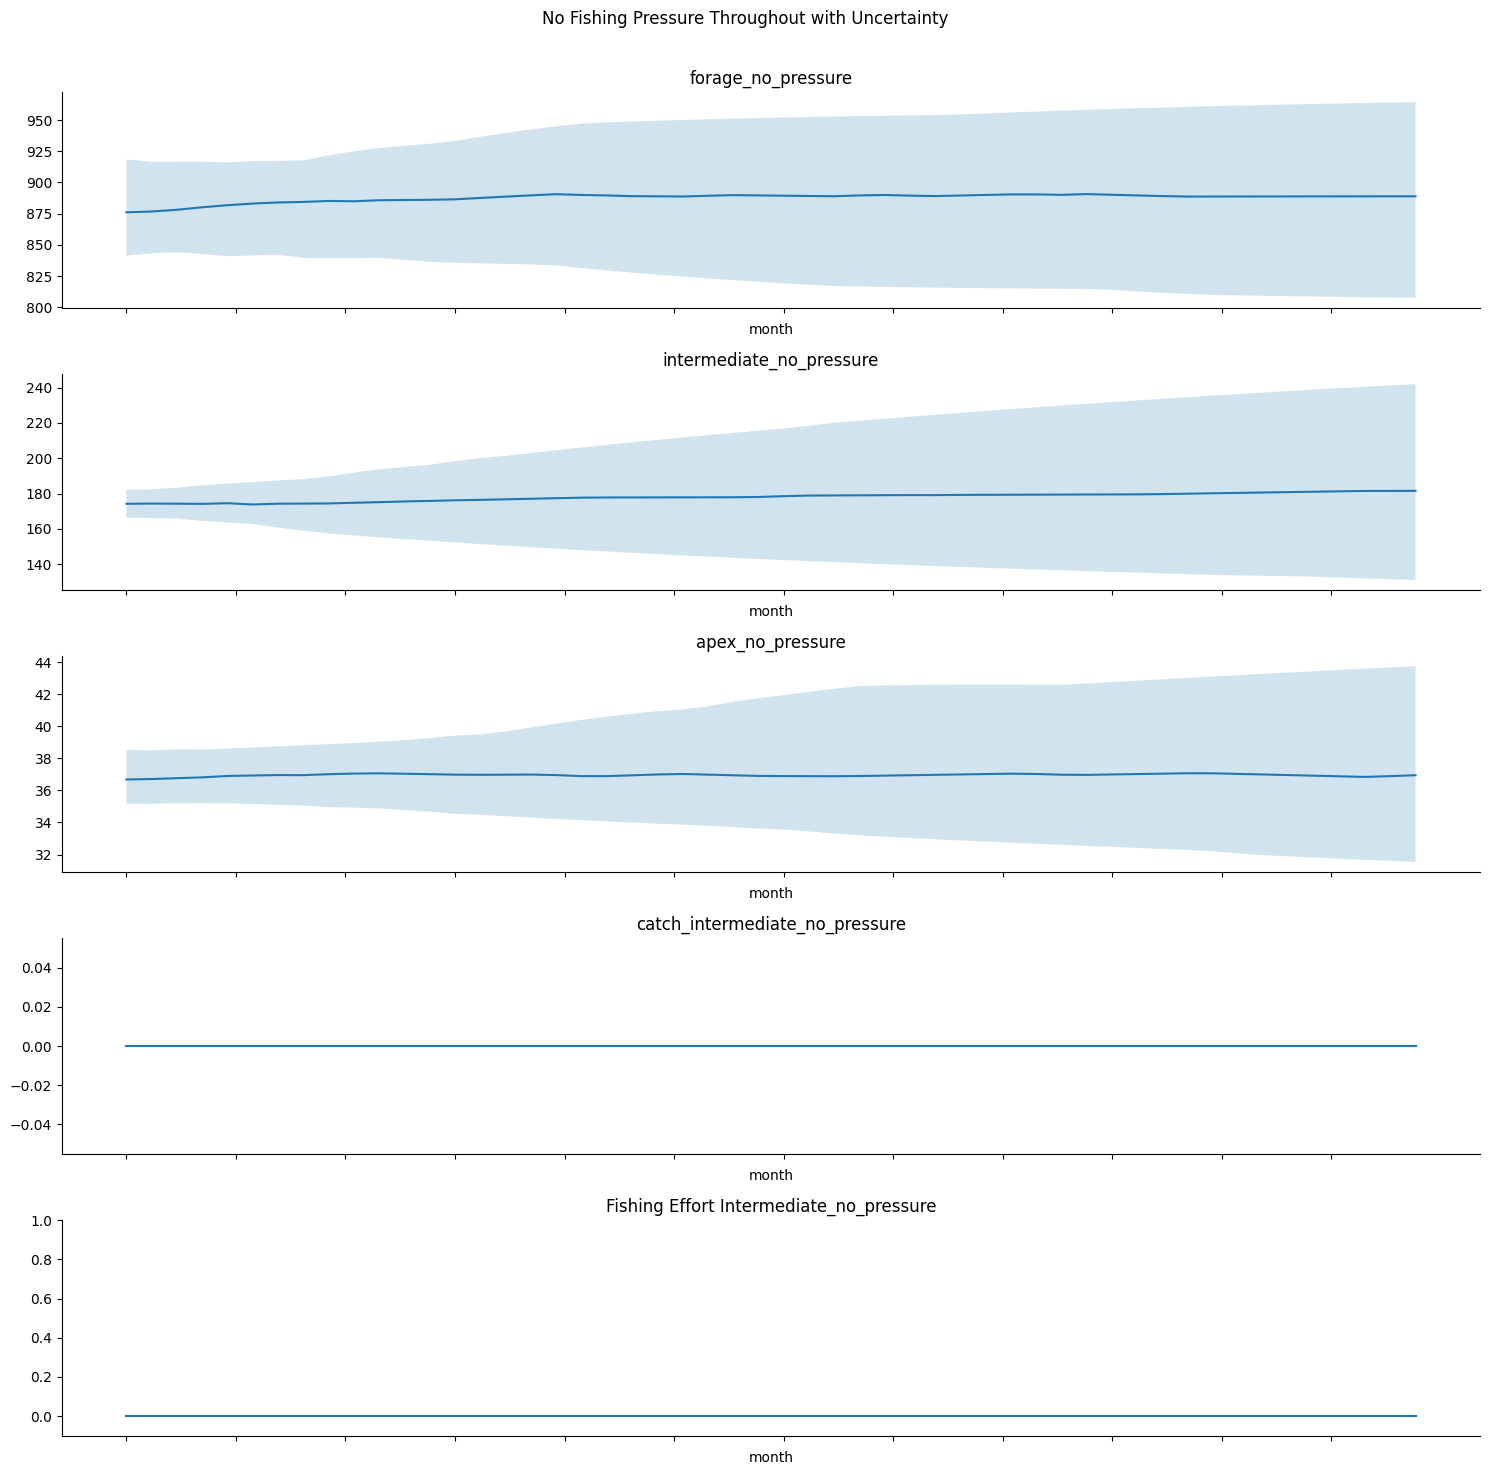

In [21]:
plot_no_pressure, ax_no_pressure = plot_trajectory_samples(no_pressure_samples, postfix = "no_pressure", 
title = "No Fishing Pressure Throughout with Uncertainty")

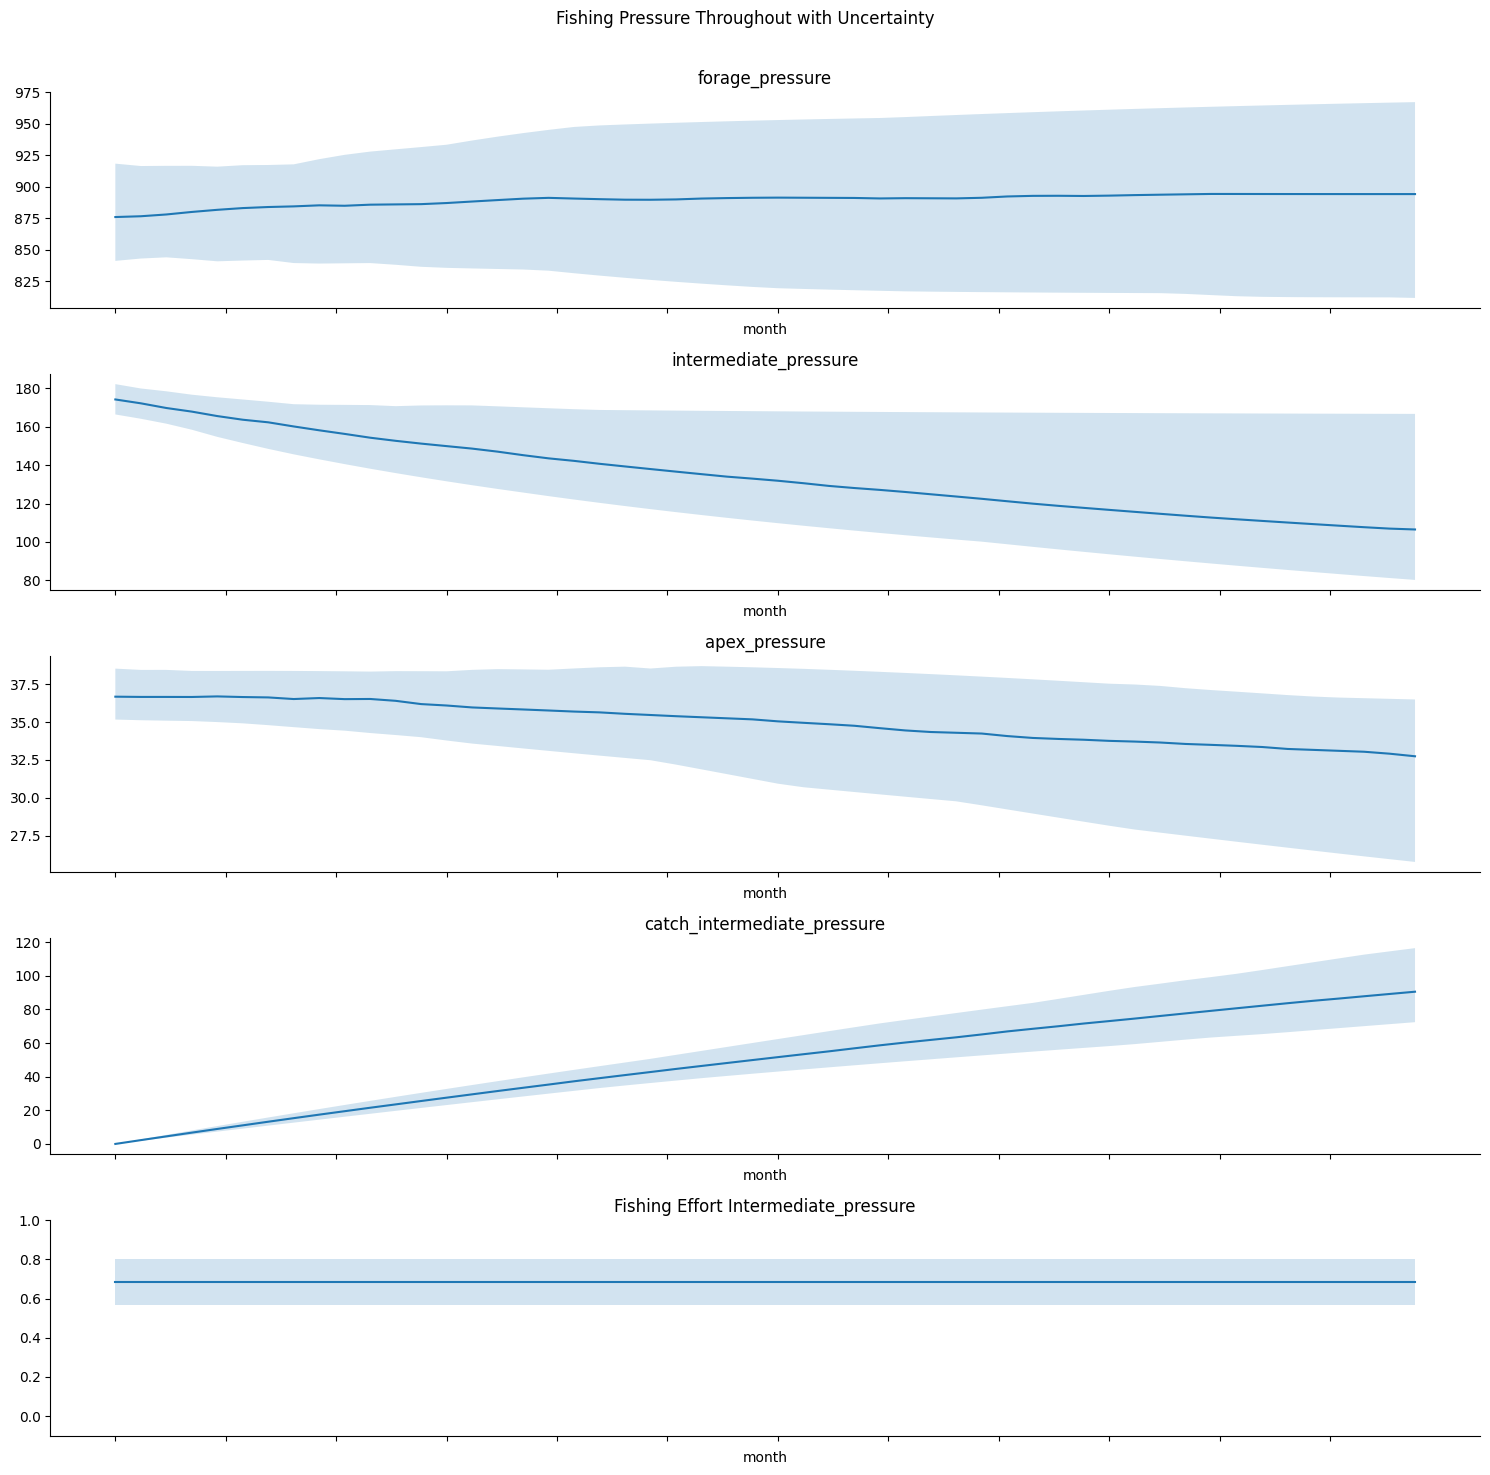

In [22]:
plot_pressure, ax_pressure = plot_trajectory_samples(pressure_samples, postfix = "pressure", title =  "Fishing Pressure Throughout with Uncertainty")

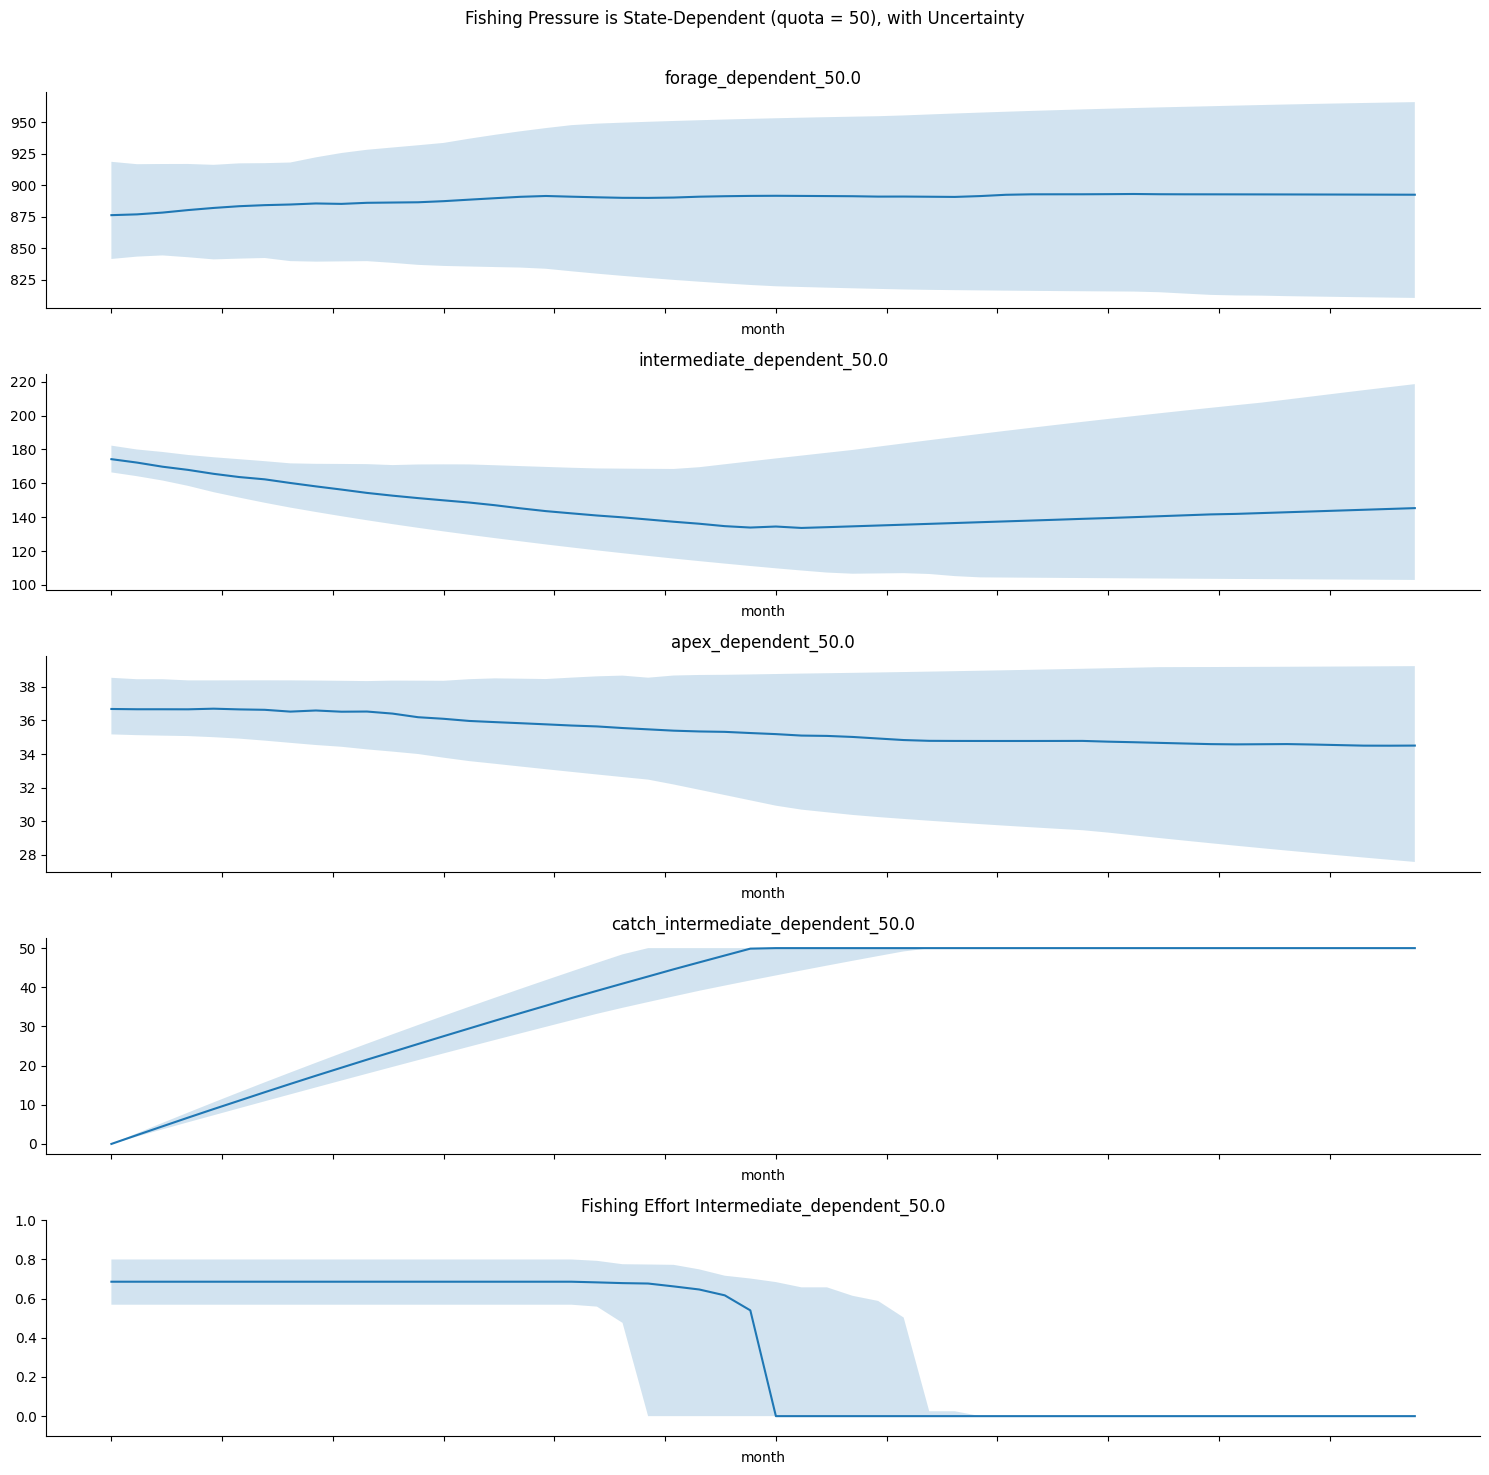

In [23]:
plot_dependent, ax_dependent = plot_trajectory_samples(dependent_samples[50.0], postfix = "dependent_50.0", 
title =  "Fishing Pressure is State-Dependent (quota = 50), with Uncertainty")

In [24]:
print(no_pressure_samples.keys())

def summarize_states(samples):
  samples_medians = {key: value.median(dim = 0).values for key, value in samples.items()}
  samples_lows = {key: value.quantile(0.05, dim = 0) for key, value in samples.items()}
  samples_highs = {key: value.quantile(0.95, dim = 0) for key, value in samples.items()}

  return samples_medians, samples_lows, samples_highs


no_pressure_samples_medians, no_pressure_samples_lows, no_pressure_samples_highs = summarize_states(no_pressure_samples)
pressure_samples_medians, pressure_samples_lows, pressure_samples_highs = summarize_states(pressure_samples)
dependend_50_samples_medians, dependend_50_samples_lows, dependend_50_samples_highs = summarize_states(dependent_samples[50.0])

dict_keys(['forage_no_pressure', 'intermediate_no_pressure', 'apex_no_pressure', 'catch_intermediate_no_pressure', 'fishing_effort_forage_no_pressure', 'fishing_effort_intermediate_no_pressure', 'fishing_effort_apex_no_pressure'])


12 12


/tmp/ipykernel_212710/4183528813.py:80: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  joint_fig.show()


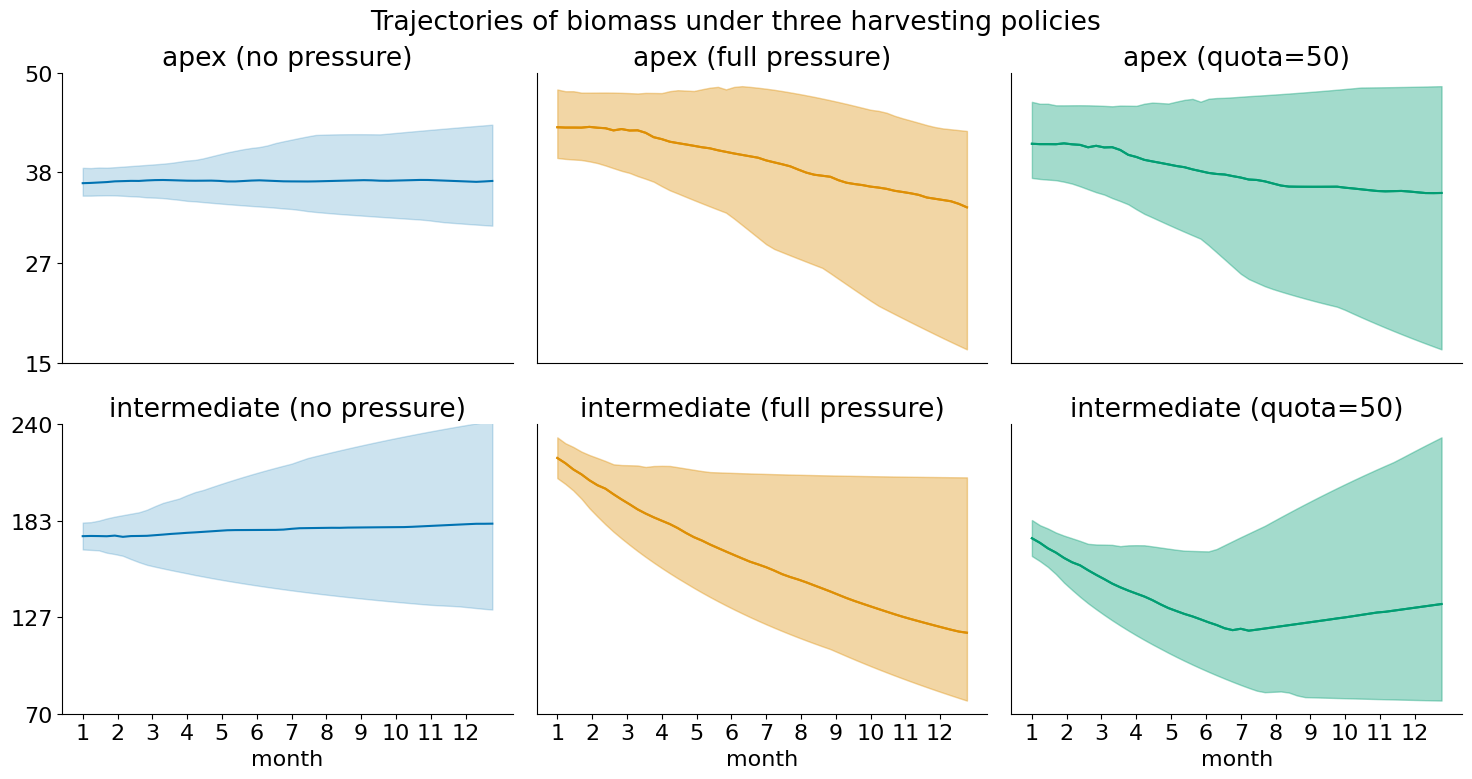

In [25]:
x_ticks = torch.arange(logging_times.min(), logging_times.max(), 1/12)
x_labels = range(1, 13)

print(len(x_ticks), len(x_labels))
key_cores = [ 'apex', 'intermediate',  ]

ylim = [(15, 50), (70, 240)]


plt.rcParams.update({'font.size': 16})

colors = sns.color_palette("colorblind", n_colors=len(key_cores)*3)

joint_fig, joint_ax = plt.subplots(2, 3, figsize=(15, 8))


for i, key in enumerate(key_cores):
  joint_ax[i, 0].plot(logging_times,
   no_pressure_samples_medians[f'{key}_no_pressure'], label=f'{key}_no_pressure', color=colors[0])
  
  joint_ax[i, 0].set_title(f'{key} (no pressure)')
  joint_ax[i, 0].fill_between(
      logging_times,
      no_pressure_samples_lows[f'{key}_no_pressure'],
      no_pressure_samples_highs[f'{key}_no_pressure'],
      alpha=0.2, color=colors[0]
  )



  joint_ax[i, 0].set_ylim(ylim[i])
  yticks = np.linspace(*ylim[i], 4).round(0)
  joint_ax[i,0].set_yticks(yticks)


  for i, key in enumerate(key_cores):

    joint_ax[i, 1].plot(logging_times,
      pressure_samples_medians[f'{key}_pressure'], label=f'{key}_pressure', color=colors[1])
    joint_ax[i, 1].set_title(f'{key} (full pressure)')
    joint_ax[i, 1].fill_between(
        logging_times,
        pressure_samples_lows[f'{key}_pressure'],
        pressure_samples_highs[f'{key}_pressure'],
        alpha=0.2, color=colors[1]
    )

    joint_ax[i, 2].plot(logging_times,
      dependend_50_samples_medians[f'{key}_dependent_50.0'], label=f'{key}_dependent_50.0', color=colors[2])
    joint_ax[i, 2].set_title(f'{key} (quota=50)')
    joint_ax[i, 2].fill_between(
        logging_times,
        dependend_50_samples_lows[f'{key}_dependent_50.0'],
        dependend_50_samples_highs[f'{key}_dependent_50.0'],
        alpha=0.2, color=colors[2]
    )
 
 
for i in range(2):
  for m in (1, 2):
    joint_ax[i, m].tick_params(axis='y', left=False, labelleft=False)


for i in range(3):
  joint_ax[0, i].set_xticks([])
  joint_ax[0, i].set_xticklabels([])

  joint_ax[1, i].set_xticks(x_ticks)
  joint_ax[1, i].set_xticklabels(x_labels)
  joint_ax[1,i].set_xlabel("month")


joint_fig.tight_layout()


sns.despine()

joint_fig.suptitle("Trajectories of biomass under three harvesting policies",)
joint_fig.subplots_adjust(top=0.9) 
joint_fig.show()

joint_fig.savefig("figures/fishery_trajectories.pdf", dpi=300)

/tmp/ipykernel_212710/1037110699.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  catch_fig.show()


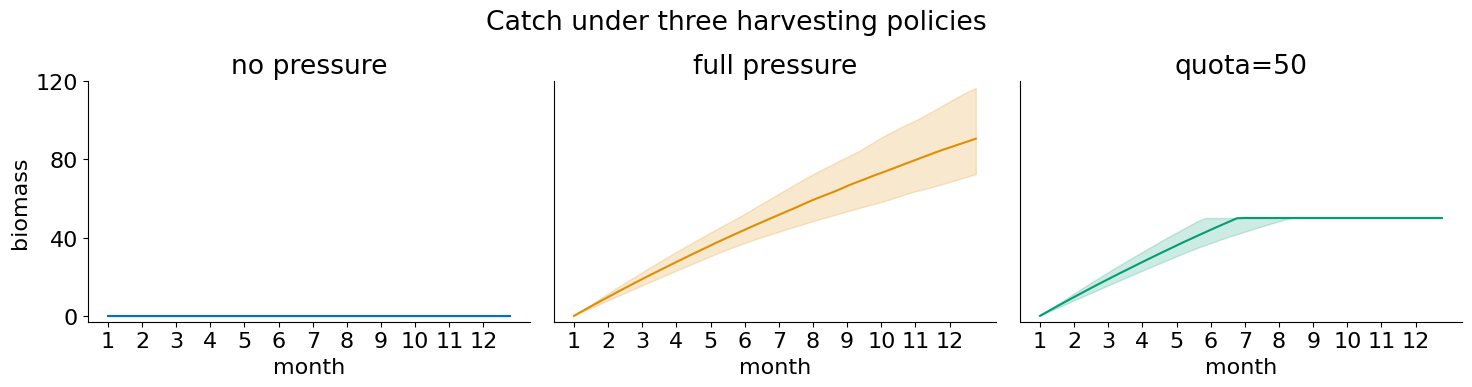

In [ ]:
catch_fig, catch_ax = plt.subplots(1, 3, figsize=(15, 4), sharey = True)

catch_ax = catch_ax.flatten()

ylim = (-3, 117)

key = 'catch_intermediate'

catch_ax[0].plot(logging_times,
    no_pressure_samples_medians[f'{key}_no_pressure'], label=f'{key}_no_pressure', color=colors[0])
  
catch_ax[0].set_title(f'no pressure')
catch_ax[0].fill_between(
    logging_times,
    no_pressure_samples_lows[f'{key}_no_pressure'],
    no_pressure_samples_highs[f'{key}_no_pressure'],
    alpha=0.2, color=colors[0]
)



catch_ax[0].set_xlabel("month")
catch_ax[0].set_ylabel("biomass")


catch_ax[1].plot(logging_times,
    pressure_samples_medians[f'{key}_pressure'], label=f'{key}_pressure', color=colors[1])

catch_ax[1].set_title(f'full pressure')
catch_ax[1].fill_between(
    logging_times,
    pressure_samples_lows[f'{key}_pressure'],
    pressure_samples_highs[f'{key}_pressure'],
    alpha=0.2, color=colors[1]
)


catch_ax[1].set_xlabel("month")


for i in range(3):
   catch_ax[i].set_ylim(ylim)
   yticks = np.linspace(*ylim, 4).round(0)+3
   catch_ax[i].set_yticks(yticks)
   catch_ax[i].set_xticks(x_ticks)
   catch_ax[i].set_xticklabels(x_labels)
    



catch_ax[2].plot(logging_times,
    dependend_50_samples_medians[f'{key}_dependent_50.0'], label=f'{key}_dependent_50.0', color=colors[2])
catch_ax[2].set_title(f'quota=50')
catch_ax[2].fill_between(
    logging_times,
    dependend_50_samples_lows[f'{key}_dependent_50.0'],
    dependend_50_samples_highs[f'{key}_dependent_50.0'],
    alpha=0.2, color=colors[2]
)

catch_ax[2].set_xlabel("month")

for i in (1, 2):
    catch_ax[i].tick_params(axis='y', left=False, labelleft=False)


catch_fig.tight_layout()

sns.despine()

catch_fig.suptitle("Catch under three harvesting policies",)
catch_fig.subplots_adjust(top=0.8) 
catch_fig.show()

catch_fig.savefig("figures/catch_trajectories.pdf", dpi=300)

## <a id='toc3_'></a>[Probabilities of causation](#toc0_)

In [27]:
threshold = torch.tensor(130.)

def causation_probabilities_from_outcomes(outcome_factual: torch.Tensor, outcome_counterfactual: torch.Tensor,  threshold: torch.Tensor = threshold):

    #---------
    #necessity

  
    mask_nec = outcome_factual > threshold
    outcome_nec = outcome_counterfactual[mask_nec]

  
    prob_nec = (outcome_nec <= threshold).float().mean()
    #-------

    #------
    #sufficiency
    
    mask_suff = outcome_factual <= threshold
    outcome_suff = outcome_counterfactual[mask_suff]

    
    prob_suff = (outcome_suff > threshold).float().mean()
    #------

    #------
    #necessity and sufficiency

    # no masking, as no conditioning
    # evaluate frequency of (Y in q) and (Y' in baseline)
    prob_nec_suff = ((outcome_factual < threshold) * (outcome_counterfactual >= threshold)).float().mean()

    #------

    return {"nec": prob_nec, "suff": prob_suff, "nec_suff": prob_nec_suff, 
    "outcome_factual": outcome_factual, "outcome_counterfactual": outcome_counterfactual,}




def causation_probabilities_from_quota(dependent_samples: Dict, factual_quota: float, counterfactual_quota: float, threshold = threshold):

    outcome_counterfactual = dependent_samples[counterfactual_quota][f"intermediate_dependent_{str(counterfactual_quota)}"][:, -1]

    outcome_factual = dependent_samples[factual_quota][f"intermediate_dependent_{str(factual_quota)}"][:, -1]

    return causation_probabilities_from_outcomes(outcome_factual, outcome_counterfactual, threshold)


In [28]:
quota_list = [float(x) for x in range(0, 121, 5)]
probabilities_of_necessity = np.zeros((len(quota_list), len(quota_list)))
probabilities_of_sufficiency = np.zeros((len(quota_list), len(quota_list)))
probabilities_of_necessity_and_sufficiency = np.zeros((len(quota_list), len(quota_list)))
indices_df = pd.DataFrame(index=quota_list, columns=quota_list)


for i, quota_i in enumerate(quota_list):
    for j, quota_j in enumerate(quota_list):
        causation_dictionary = causation_probabilities_from_quota(dependent_samples=dependent_samples,
         factual_quota=quota_i, 
         counterfactual_quota=quota_j)

        probabilities_of_necessity[j, i] = causation_dictionary['nec']
        probabilities_of_sufficiency[j, i] = causation_dictionary['suff']
        probabilities_of_necessity_and_sufficiency[j, i] = causation_dictionary['nec_suff']
        indices_df.iloc[j, i] = (quota_j, quota_i)

/tmp/ipykernel_212710/1086773067.py:201: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


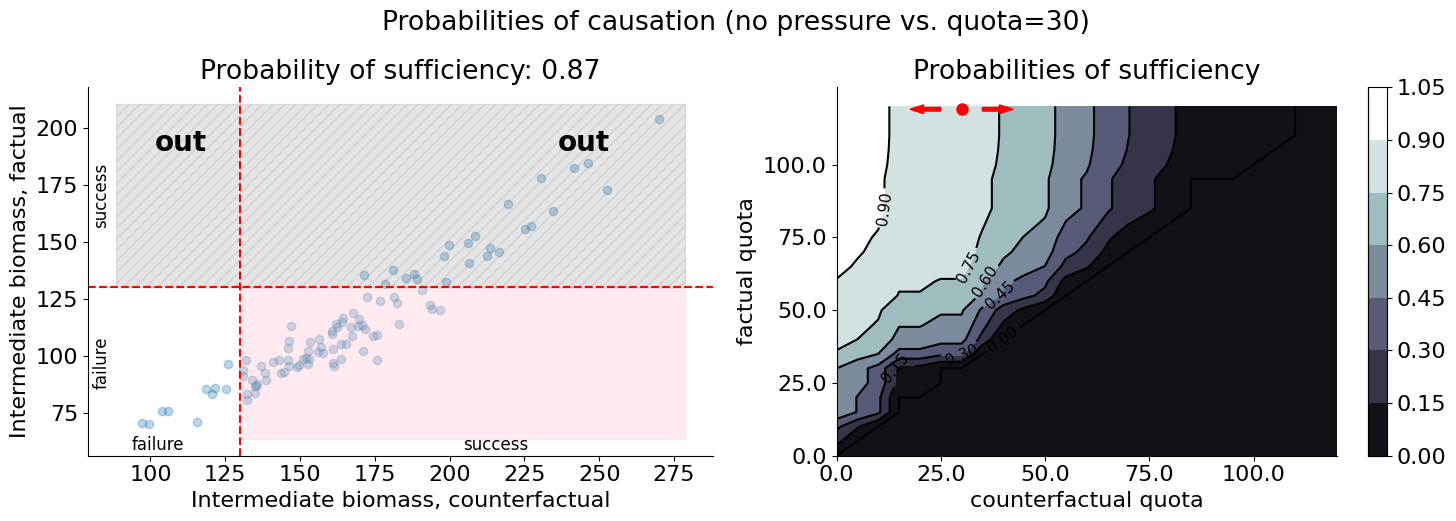

In [29]:
def plot_causation_pair(factual_quota = None, counterfactual_quota = None, postfix = "", type = None,
        fig_path = None, dot_coordinates = None,):

    causation_dictionary = causation_probabilities_from_quota(dependent_samples,
                            factual_quota = float(factual_quota),  counterfactual_quota = float(counterfactual_quota))

    prob_nec = causation_dictionary["nec"]
    prob_suff = causation_dictionary["suff"]
    prob_nec_suff = causation_dictionary["nec_suff"]
    outcome_counterfactual = causation_dictionary["outcome_counterfactual"]
    outcome_factual = causation_dictionary["outcome_factual"]

    mask_nec = outcome_factual > threshold
    mask_suff = outcome_factual <= threshold

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    axes = ax.flatten()

    axes[0].scatter(outcome_counterfactual, outcome_factual, alpha=0.3)
    
    axes[0].set_xlabel("Intermediate biomass, counterfactual")
    axes[0].set_ylabel("Intermediate biomass, factual")
    axes[0].axvline(threshold, color='red', linestyle='--')
    axes[0].axhline(threshold, color='red', linestyle='--')

    xlim = axes[0].get_xlim() 
    ylim = axes[0].get_ylim() 
    
  
    axes[0].text(xlim[0]+5, ylim[0]-5, 'failure', fontsize=12)
    axes[0].text(threshold.item() + (xlim[1] - threshold.item())/2, 
            ylim[0]-5, "success", fontsize=12)


    axes[0].text(xlim[0] - 5, ylim[0] + (threshold.item() - ylim[0]) / 2, 'failure',
     fontsize=12, rotation=90, ha='center', va='center')

    axes[0].text(xlim[0] - 5, threshold.item() + (ylim[1]- threshold.item()) / 2, 'success',
     fontsize=12, rotation=90, ha='center', va='center')


    if type == "sufficient and necessary":
        axes[0].set_title(f"Probability of necessity and sufficiency: {prob_nec_suff:.2f}")
        axes[0].fill_betweenx(y=np.linspace(ylim[0], threshold, 100), x1=threshold, x2=xlim[1], color='pink', alpha=0.3)

        axes[0].fill_betweenx(
        y=np.linspace(ylim[0], threshold, 100),
        x1=xlim[0],
        x2=xlim[1],
        color='white',
        alpha=0.2
        )

        axes[0].set_ylabel("Intermediate biomass, baseline")
        axes[0].set_xlabel("Intermediate biomass, intervention")


        contour_probabilities = probabilities_of_necessity_and_sufficiency.T
        contour_title = "Probabilities of necessity and sufficiency"
        


    if type == "necessary":

        contour_probabilities = probabilities_of_necessity.T
        contour_title = "Probabilities of necessity"

        

        axes[0].set_title(f"Probability of necessity: {prob_nec:.2f}")

        axes[0].fill_betweenx(y=np.linspace(threshold, ylim[1], 100), x1=xlim[0], x2=threshold, color='pink', alpha=0.3)

        axes[0].fill_betweenx(
        y=np.linspace(ylim[0], threshold, 100),
        x1=xlim[0],
        x2=xlim[1],
        color='grey',
        hatch='///',
        alpha=0.2
        )

        axes[0].text(
        #(xlim[0] + xlim[1]) / 3 ,
        threshold - 20,
        (ylim[0] + threshold) / 2,
        "out",
        color='black',
        fontsize=20,
        ha='center',
        va='center',
        fontweight='bold'
        )

        axes[0].text(
        2 * ((xlim[0] + xlim[1]) / 3 ),
        (ylim[0] + threshold) / 2,
        "out",
        color='black',
        fontsize=20,
        ha='center',
        va='center',
        fontweight='bold'
        )

  

    if type == "sufficient":

        contour_probabilities = probabilities_of_sufficiency.T
        contour_title = "Probabilities of sufficiency"

        axes[0].set_title(f"Probability of sufficiency: {prob_suff:.2f}")

        axes[0].fill_betweenx(y=np.linspace(ylim[0], threshold, 100), x1=threshold, x2=xlim[1], color='pink', alpha=0.3)


        axes[0].fill_betweenx(
        y=np.linspace(threshold, ylim[1], 100),
        x1=xlim[0],
        x2=xlim[1],
        color='grey',
        #edgecolor='black',
        hatch='///',
        alpha=0.2
        )

        axes[0].text(
        #((xlim[0] + xlim[1]) / 3 ),
        threshold - 20,
        (ylim[0] + threshold) ,
        "out",
        color='black',
        fontsize=20,
        ha='center',
        va='center',
        fontweight='bold'
        )

        axes[0].text(
        2 * ((xlim[0] + xlim[1]) / 3 ),
        (ylim[0] + threshold) ,
        "out",
        color='black',
        fontsize=20,
        ha='center',
        va='center',
        fontweight='bold'
        )

    vmin = np.min(contour_probabilities)
    vmax = np.max(contour_probabilities)


    contour= axes[1].contourf(contour_probabilities, cmap='bone', vmin=vmin, vmax=vmax)

    contour_lines = axes[1].contour(contour_probabilities, colors='black') 

    axes[1].clabel(contour_lines, inline=True, fontsize=11)

    fig.colorbar(contour, ax=axes[1])

    step = 5  # To get every second value
    axes[1].set_xticks(np.arange(0, len(quota_list), step))  # Set every second tick on the x-axis
    axes[1].set_xticklabels([quota_list[i] for i in range(0, len(quota_list), step)])  

    axes[1].set_yticks(np.arange(0, len(quota_list), step))  # Set every second tick on the y-axis
    axes[1].set_yticklabels([quota_list[i] for i in range(0, len(quota_list), step)])



    axes[1].set_ylabel("factual quota")
    axes[1].set_xlabel("counterfactual quota")
    axes[1].set_title(contour_title)

    if type == "sufficient and necessary":
        axes[1].set_ylabel("status quo")
        axes[1].set_xlabel("proposed quota")


    
    
    if dot_coordinates is not None:
        x, y = dot_coordinates
        axes[1].plot(dot_coordinates[0], dot_coordinates[1],  'ro', markersize=8)
        arrow_length = .82


        arrow_params = dict(head_width=.6, head_length=.65, width = .25, color='red')
        axes[1].arrow(x+1, y, arrow_length, 0, **arrow_params, zorder=10) 
        axes[1].arrow(x-1, y, - arrow_length, 0,  **arrow_params, zorder =10)


    sns.despine()
    fig.tight_layout()
    fig.suptitle(f"Probabilities of causation {postfix}", y=1.05)

    if fig_path is not None:
        fig.savefig(fig_path, dpi=300)
    fig.show()



step1 = plot_causation_pair(factual_quota = 120, counterfactual_quota = 30,
     postfix = "(no pressure vs. quota=30)", type = "sufficient",
     dot_coordinates = (6, 23.8),
    fig_path = "figures/causation_120_30_step1.pdf")

/tmp/ipykernel_212710/1086773067.py:201: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


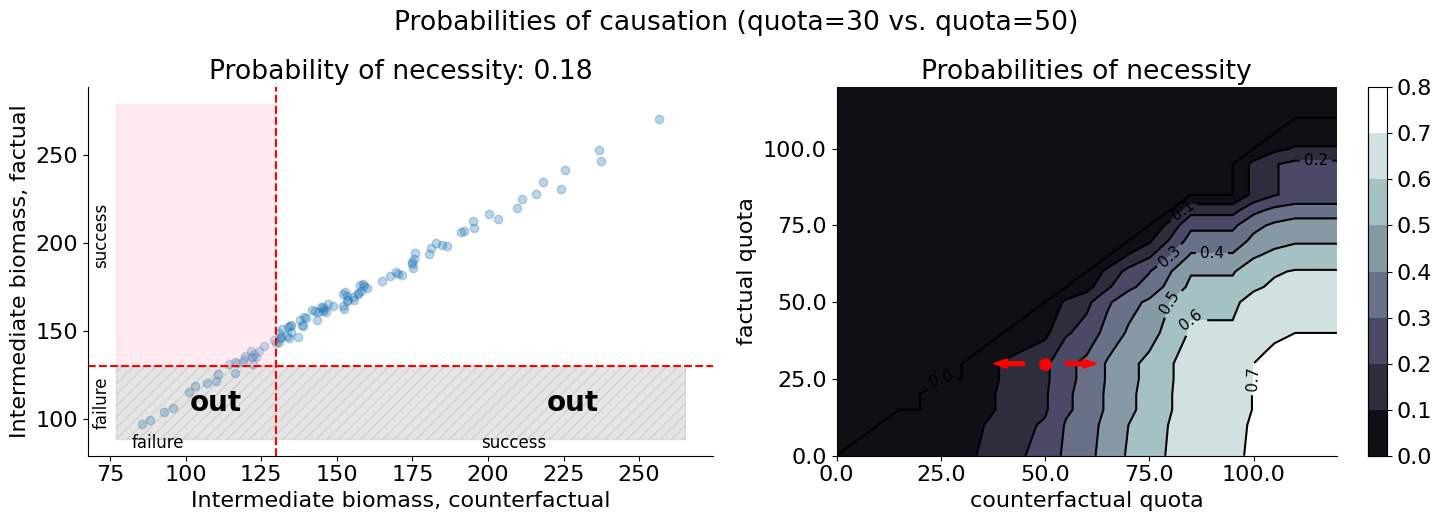

In [30]:
plot_causation_pair(factual_quota = 30, counterfactual_quota = 50, postfix = "(quota=30 vs. quota=50)",
fig_path = "figures/causation_30_50_step2.pdf", 
 type = "necessary",
dot_coordinates = (10, 6))

/tmp/ipykernel_212710/1086773067.py:201: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


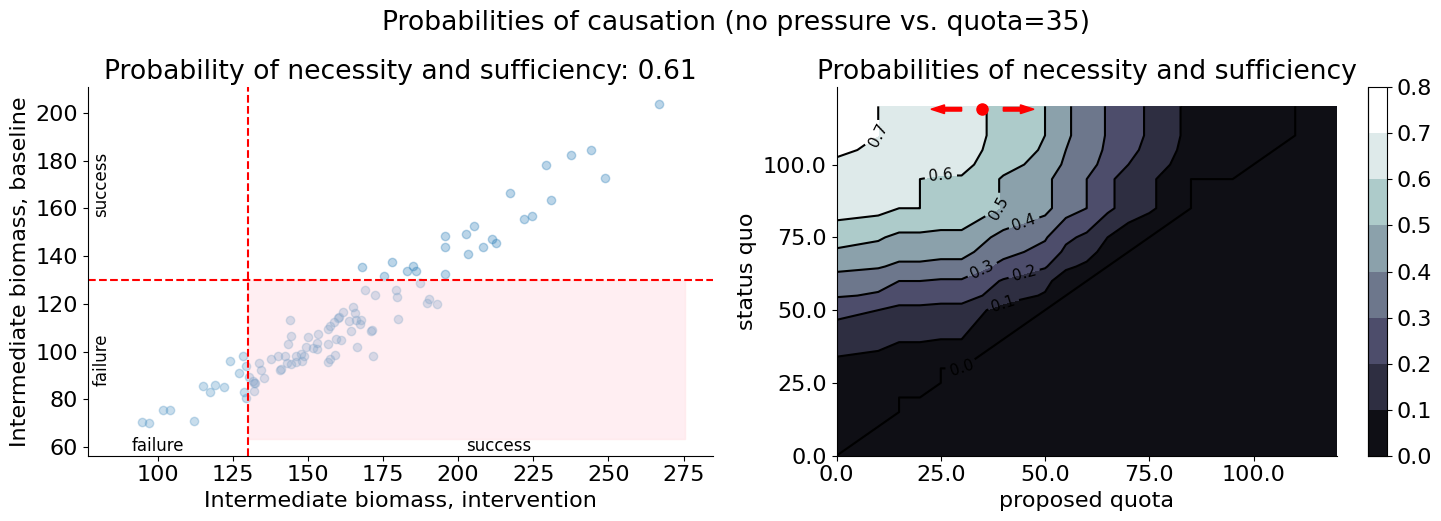

In [31]:
plot_causation_pair(factual_quota = 120, counterfactual_quota = 35, postfix = "(no pressure vs. quota=35)",
dot_coordinates = (7, 23.8),
fig_path = "figures/causation_120_35_step3.pdf",
type = "sufficient and necessary")

In [32]:
# against the baseline of full fishing pressure

outcome_pressure = pressure_samples['intermediate_pressure'][:,-1]

quota_list
probabilities_of_necessity = []
probabilities_of_sufficiency = []
probabilities_of_necessity_and_sufficiency = []

for quota in quota_list:
    outcome_factual = dependent_samples[quota][f"intermediate_dependent_{str(quota)}"][:, -1]

    causation_dictionary = causation_probabilities_from_outcomes(outcome_factual, outcome_pressure)

    probabilities_of_necessity.append(causation_dictionary['nec'])
    probabilities_of_sufficiency.append(causation_dictionary['suff'])
    probabilities_of_necessity_and_sufficiency.append(causation_dictionary['nec_suff'])

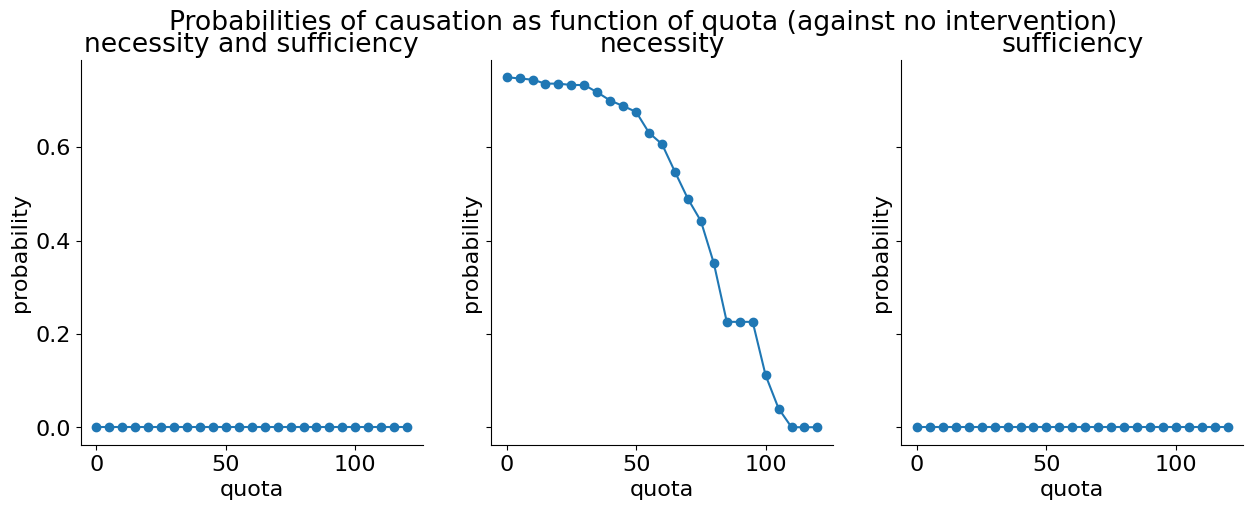

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

ax = ax.flatten()

ax[1].plot(quota_list, probabilities_of_necessity)
ax[1].scatter(quota_list, probabilities_of_necessity)
ax[1].set_title("necessity")

ax[2].plot(quota_list, probabilities_of_sufficiency)
ax[2].scatter(quota_list, probabilities_of_sufficiency)
ax[2].set_title("sufficiency")

ax[0].plot(quota_list, probabilities_of_necessity_and_sufficiency)
ax[0].scatter(quota_list, probabilities_of_necessity_and_sufficiency)
ax[0].set_title("necessity and sufficiency")

for i in range(3):
    ax[i].set_xlabel("quota")
    ax[i].set_ylabel("probability")



sns.despine()

plt.suptitle("Probabilities of causation as function of quota (against no intervention)")
plt.show()

In [34]:
quota_list
probabilities_of_necessity_20 = []
probabilities_of_sufficiency_20 = []
probabilities_of_necessity_and_sufficiency_20 = []

for quota in quota_list:

    causation_dictionary = causation_probabilities_from_quota(dependent_samples, quota, 20.0)

    probabilities_of_necessity_20.append(causation_dictionary['nec'])
    probabilities_of_sufficiency_20.append(causation_dictionary['suff'])
    probabilities_of_necessity_and_sufficiency_20.append(causation_dictionary['nec_suff'])

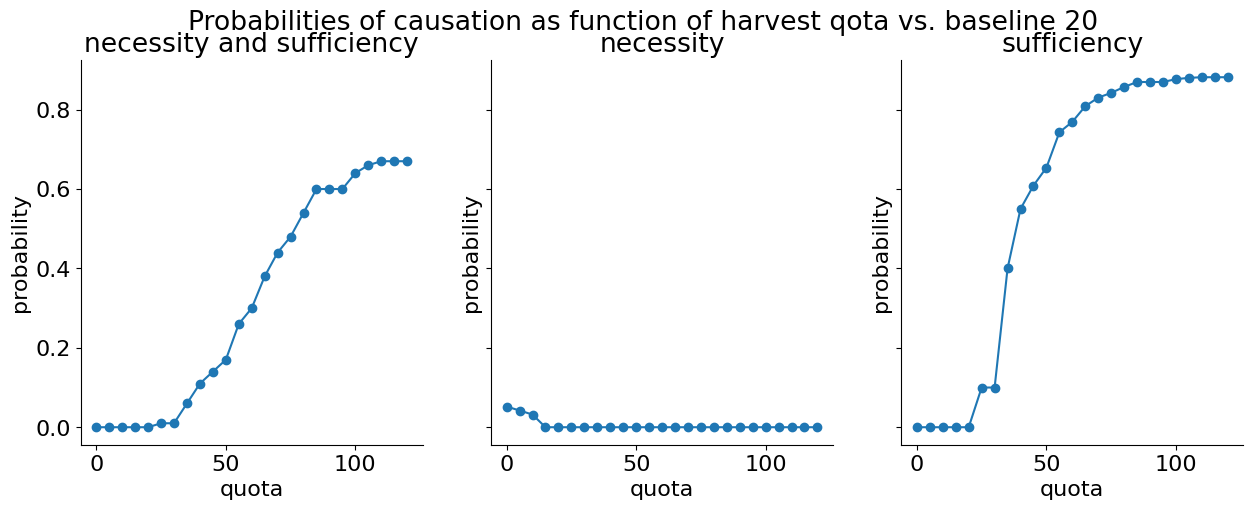

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

ax = ax.flatten()

ax[1].plot(quota_list, probabilities_of_necessity_20)
ax[1].scatter(quota_list, probabilities_of_necessity_20)
ax[1].set_title("necessity")

ax[2].plot(quota_list, probabilities_of_sufficiency_20)
ax[2].scatter(quota_list, probabilities_of_sufficiency_20)
ax[2].set_title("sufficiency")

ax[0].plot(quota_list, probabilities_of_necessity_and_sufficiency_20)
ax[0].scatter(quota_list, probabilities_of_necessity_and_sufficiency_20)
ax[0].set_title("necessity and sufficiency")

for i in range(3):
    ax[i].set_xlabel("quota")
    ax[i].set_ylabel("probability")



sns.despine()

plt.suptitle("Probabilities of causation as function of harvest qota vs. baseline 20")
plt.show()

## <a id='toc4_'></a>[Time-of-event interventions](#toc0_)

In [36]:
class LogTrajectoryAndInterventionTime(LogTrajectory):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.recorded_interruption_time = False
    def _pyro_post_simulate_to_interruption(self, msg):
        if not self.recorded_interruption_time:
            self.recorded_interruption_time = True
            self.interruption_time = msg['value'][1]
            self.interruption_state = msg['value'][0]
            if self.is_traced:       
                pyro.deterministic("interruption_time", msg['value'][1])
                for key in self.interruption_state.keys():
                    pyro.deterministic(f"interruption_state_{key}", msg['value'][0][key])
                

In [37]:
intervention_grid_size = 30
threshold = torch.tensor(130.)
quota = {'catch_intermediate_dependent': 40.0}


def TOE_dynamics(num_samples, intervention_grid_size, threshold = threshold, quota = quota, minimal_cutoff_point = torch.tensor(0.3)):


    noise_keys = ['r1', 'r2', 'r3', 'd1', 'd2', 'm3', 'k1', 'p12', 'p23', 'e12', 'e23']

    def internal_dynamics():

        shared_noise = sample_fishery_priors()

 
        fish_dynamics_state_dependent = FishDynamics(params = shared_noise, postfix = "dependent")

        with TorchDiffEq(),LogTrajectoryAndInterventionTime(logging_times, is_traced=True) as lt_dependent:
            with DynamicIntervention(event_fn=stop_fishing_policy(quota), intervention= season_ends):
                simulate(fish_dynamics_state_dependent, INITIAL_STATE_DEPENDENT, start_time, logging_times[-1])

    
    dynamical_predictive = Predictive(internal_dynamics, num_samples=num_samples,)
    dynamical_samples =  dynamical_predictive()


    grabbed_noise = {key: dynamical_samples[key] for key in noise_keys}

    season_ends_static = {key.replace("_dependent", "_static"): season_ends[key] for key in season_ends.keys()}


    # conditioning mask
    outcome_above_threshold_mask = dynamical_samples['intermediate_dependent'][:,-1] > threshold

    intervention_times = (torch.linspace(minimal_cutoff_point, 1, intervention_grid_size))
    intervened_outcomes = torch.zeros((num_samples, intervention_grid_size -1))
    joint_masks = []
    intervened_intermediates = []
    intervened_catches = [] #bad English, think of a better plural:)


    for intervention_index in range(intervention_grid_size -1):
        intervention_time = intervention_times[intervention_index]
        print("Processing lambda: ", intervention_time.item())

        
        intervention_applied_mask = dynamical_samples['interruption_time'] < intervention_time
    
        joint_mask = outcome_above_threshold_mask * intervention_applied_mask
        joint_masks.append(joint_mask)

        def static_runs():
            shared_noise = sample_fishery_priors() #will be overriden
            fish_dynamics_static = FishDynamics(params = shared_noise, postfix = "static")

            with MultiWorldCounterfactual() as mwc:
                with StaticIntervention(time = intervention_time, 
                        intervention = season_ends_static):
                    with TorchDiffEq(),LogTrajectory(logging_times, is_traced=True) as lt_static:
                        simulate(fish_dynamics_static, INITIAL_STATE_STATIC, start_time, logging_times[-1])

            catch = lt_static.trajectory['catch_intermediate_static'].squeeze()
            intermediate = lt_static.trajectory['intermediate_static'].squeeze()


            intervened_catch = pyro.deterministic("intervened_catch", catch[1,1,1,:])


            intervened_intermediate = pyro.deterministic("intervened_intermediate", intermediate[1,1,1,:])
            intervened_outcome = pyro.deterministic("intervened_outcome", intervened_intermediate[...,-1])

               
        predictive_static = Predictive(static_runs, num_samples=1,)
    
        with do(actions = grabbed_noise):
            static_samples = predictive_static()

        assert torch.allclose(static_samples['r1'], grabbed_noise['r1'])
        
        intervened_outcomes[:, intervention_index] = static_samples['intervened_outcome']
        intervened_intermediates.append(static_samples['intervened_intermediate'])
        intervened_catches.append(static_samples['intervened_catch'])
    
    intervention_times = intervention_times[...,:-1]

    return intervened_intermediates, intervened_catches,  intervened_outcomes, intervention_times, joint_masks

In [38]:
FRESH_RUN = False
pyro.clear_param_store()
torch.manual_seed(42)
pyro.set_rng_seed(42)

fishery_timed_samples_path = "fishery_timed_samples.pkl"
if os.path.exists(fishery_timed_samples_path) and not FRESH_RUN:
    print("Loading timed fishery samples")
    with open(fishery_timed_samples_path, "rb") as f:
        intervened_intermediates, intervened_catches, intervened_outcomes, intervention_times, joint_masks = pickle.load(f)
else:
    print("Running timed fishery sampling")
    intervened_intermediates, intervened_catches, intervened_outcomes, intervention_times, joint_masks = TOE_dynamics(num_samples=1000,
                     intervention_grid_size=intervention_grid_size)

    with open(fishery_timed_samples_path, "wb") as f:
        pickle.dump((intervened_intermediates, intervened_catches, intervened_outcomes, intervention_times,  joint_masks), f)

Loading timed fishery samples


In [39]:
timewise_probabilities = []
masked_outcomes = []

for i in range(1, intervention_grid_size - 1):
    joint_mask = joint_masks[i]
    masked_outcome = intervened_outcomes[joint_mask,i]
    masked_outcomes.append(masked_outcome)
    timewise_probabilities.append((masked_outcome < threshold).float().mean())
  
assert len(timewise_probabilities) == intervention_times.shape[0] -1

# glue together two neighbors to decrease the number of violins
violin_outcomes = []
violin_unconditioned = []
violin_times = []
indices = range(intervention_grid_size - 1)[::2][1:]

for i in indices[:-1]:
    violin_outcomes.append(torch.flatten(torch.cat((masked_outcomes[i],
     masked_outcomes[i+1]))))

    

    violin_times.append(intervention_times[i+1].item()

     )

    violin_unconditioned.append(torch.flatten(
        torch.cat((intervened_outcomes[:,i],
     intervened_outcomes[:,i+1]))
        ))

In [41]:
days = [(time * 365.25) for time in violin_times]
start_date = datetime(2024, 1, 1)
actual_dates = [start_date + timedelta(days=day) for day in days]
print(actual_dates)
x_calendar_labels = [date.strftime('%m-%d') for date in actual_dates]

x_calendar_labels = [date.strftime('%b %d') for date in actual_dates]


[datetime.datetime(2024, 5, 16, 0, 34, 46, 178827), datetime.datetime(2024, 6, 2, 15, 45, 56, 400418), datetime.datetime(2024, 6, 20, 6, 57, 6, 622009), datetime.datetime(2024, 7, 7, 22, 8, 17, 784090), datetime.datetime(2024, 7, 25, 13, 19, 27, 65191), datetime.datetime(2024, 8, 12, 4, 30, 38, 227272), datetime.datetime(2024, 8, 29, 19, 41, 47, 508373), datetime.datetime(2024, 9, 16, 10, 52, 58, 670454), datetime.datetime(2024, 10, 4, 2, 4, 7, 951555), datetime.datetime(2024, 10, 21, 17, 15, 19, 113636), datetime.datetime(2024, 11, 8, 8, 26, 28, 394737), datetime.datetime(2024, 11, 25, 23, 37, 39, 556818), datetime.datetime(2024, 12, 13, 14, 48, 48, 837919)]


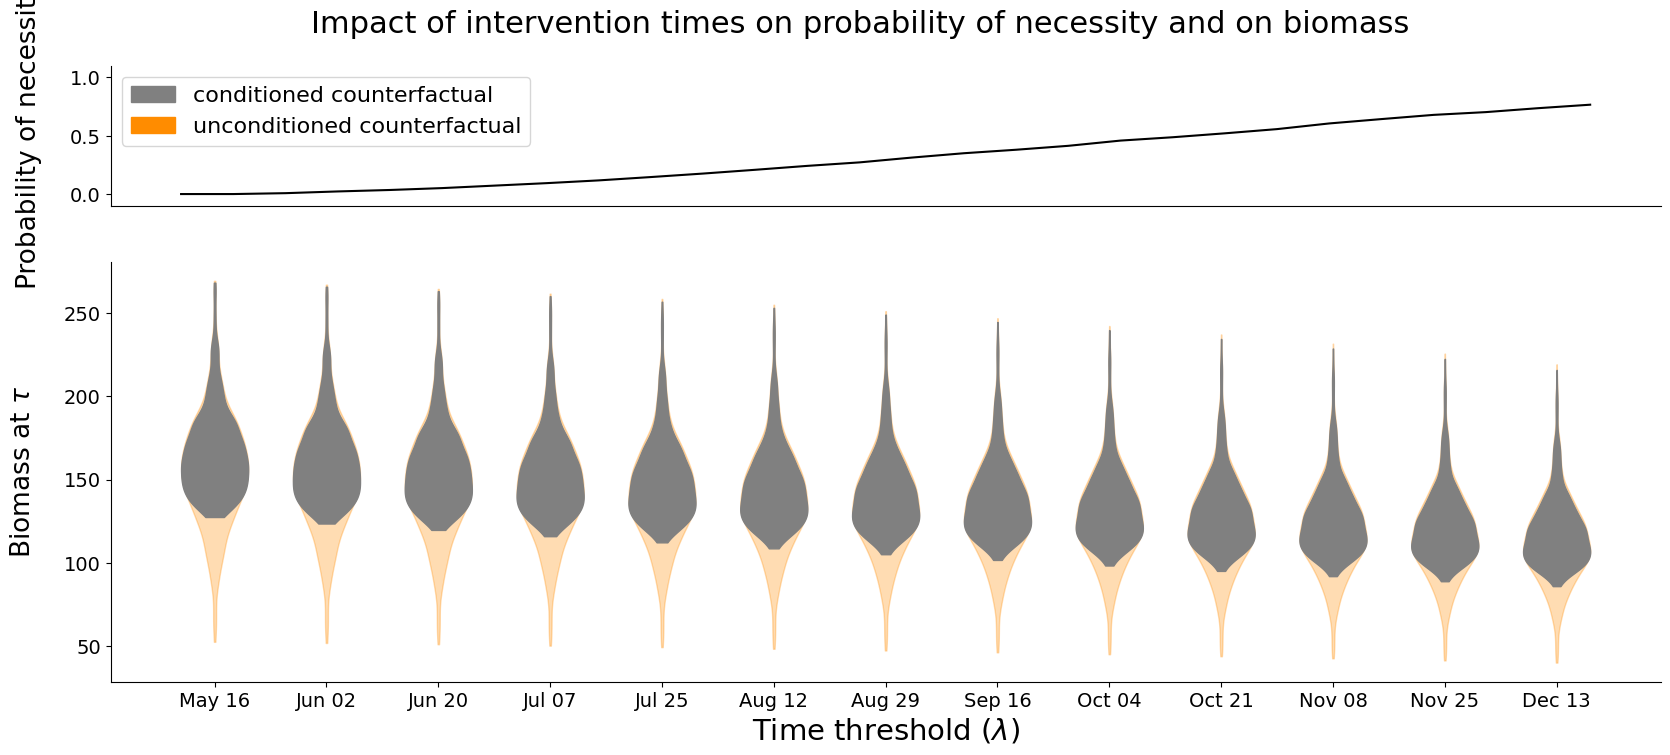

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8),
                        gridspec_kw={'height_ratios': [1, 3]})
axes = ax.flatten()



ax1 = axes[1]
ax2 = axes[0]

ax2.plot(timewise_probabilities, color='black', label='probability of necessity')
ax2.set_ylabel('Probability of necessity', color='black', labelpad=20, fontsize=19)
ax2.tick_params(axis='y', labelsize=14)
ax2.set_ylim(-0.1, 1.1)
ax2.set_xticks([])


parts2 = ax1.violinplot(
    violin_unconditioned,
    showmeans=False,
    widths=.6,
    showextrema=False,
    showmedians=False,
    points=500,
)

parts = ax1.violinplot(
    violin_outcomes,
    showmeans=False,
    widths=.6,
    showextrema=False,
    showmedians=False,
    points=500,
)



for pc in parts['bodies']:
    pc.set_alpha(1)
    pc.set_color("gray")

for pc in parts2['bodies']:
    pc.set_alpha(0.3)
    pc.set_color("darkorange")


x_ticks = range(1,14)
x_labels = x_calendar_labels


ax1.set_xlabel('Time threshold ($\\lambda$)', fontsize=21)
ax1.set_ylabel('Biomass at $\\tau$', labelpad=20, fontsize=19)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels, fontsize=14)
ax1.tick_params(axis='y', labelsize=14)

sns.despine()



red_patch = mpatches.Patch(color='gray', label='conditioned counterfactual')
blue_patch = mpatches.Patch(color='darkorange', label='unconditioned counterfactual')


ax[0].legend(handles=[red_patch, blue_patch])

fig.suptitle('Impact of intervention times on probability of necessity and on biomass',
             fontsize=22, y=.95)

plt.subplots_adjust(top=0.88)

plt_path = "figures/intervention_time_biomass_necessity.pdf"
fig.savefig(plt_path, dpi=300)
plt.show()

In [46]:
# spaghetti plot params ad auxiliaries 

start_date = datetime(2024, 1, 2)
actual_dates = [start_date + timedelta(days=(30.44 * (month - 1))) for month in range(1, 13)]
x_calendar_labels = [date.strftime('%b') for date in actual_dates]

line_steps = [2, 8, 14]


line_days = np.round(intervention_times * 365.25)[line_steps].numpy()
line_actual_days = [start_date + timedelta(days=day.item()) for day in line_days]
x_calendar_intervention_labels = [date.strftime('%b-%d') for date in line_actual_days]
x_ticks = list(range(0, 12))


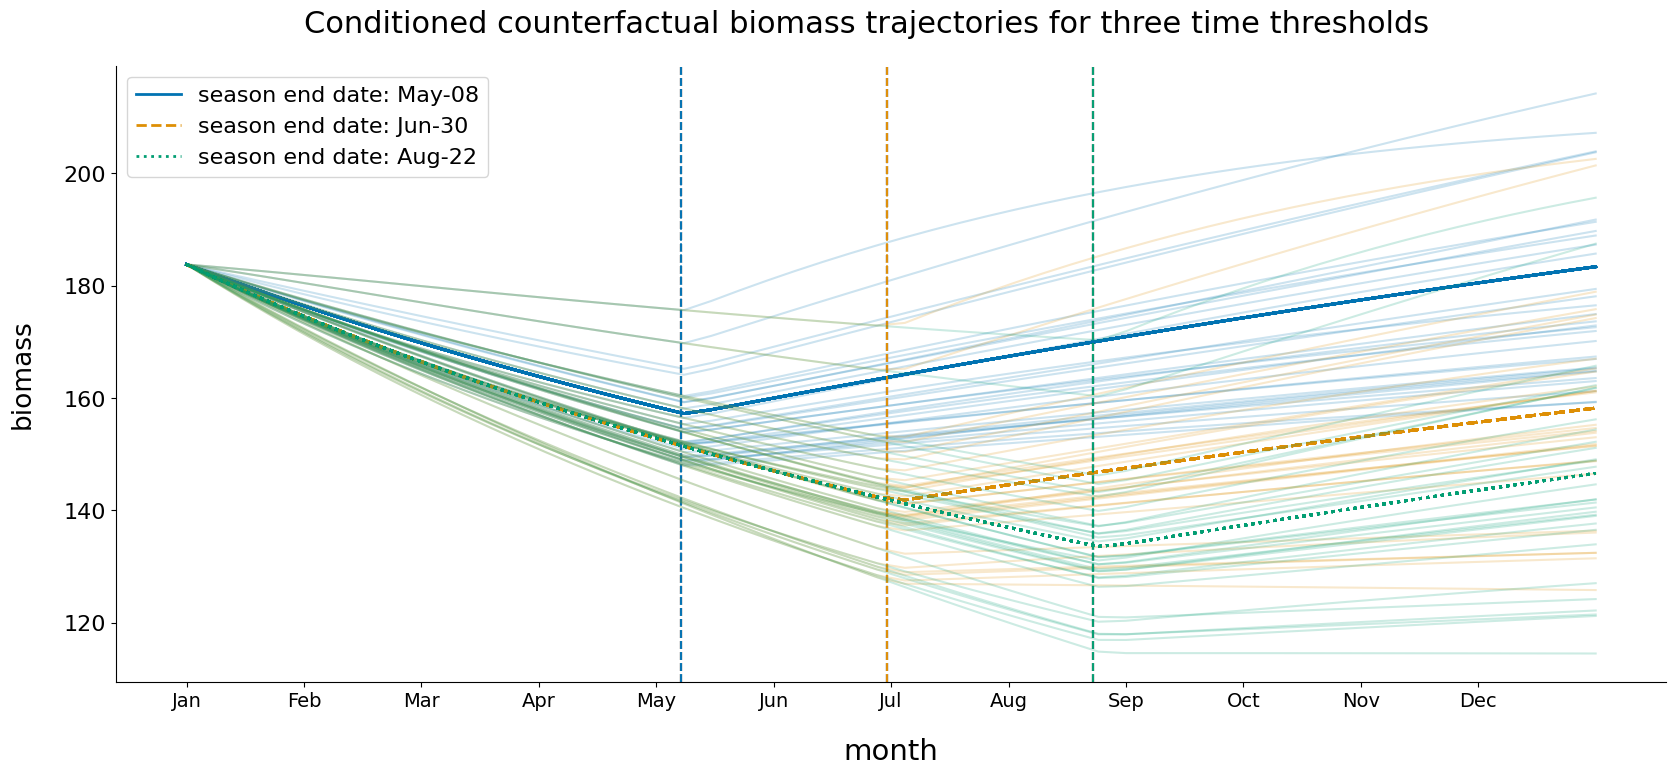

In [49]:
month_axis = np.linspace(0, 12, 52)
max_lines = 30

colors = sns.color_palette('colorblind', n_colors=len(line_steps))

fig, ax = plt.subplots(1, 1, figsize=(20, 8),)

linetypes = ['solid', 'dashed', 'dotted']

label = None
label_counter = 0
step = 0

for (i, color) in zip(line_steps, colors):


    masked_intermediates = intervened_intermediates[i][:,joint_masks[i],:].squeeze()
    masked_internediates_mean = masked_intermediates.mean(dim=0)

    masked_catch = intervened_catches[i][:,joint_masks[i],:].squeeze()
  
    linetype = linetypes[step]


    for line in range(max_lines):
        
            if line == 0:
                label = f"season end date: {x_calendar_intervention_labels[label_counter]}"
                label_counter += 1
            else:
                label = None

            ax.plot(month_axis,
            masked_intermediates[line,:], 
            color=color,
            alpha=0.2,
            label= None,
            )

            ax.plot(month_axis,
                 masked_internediates_mean, 
                color = color,
                alpha = 1,
                linewidth = 2,
                label = label,
                linestyle = linetypes[step],
            )
 
            
            ax.axvline(intervention_times[i] * 12.1, color=color, alpha=0.1, linestyle='--')

    step += 1


ax.set_xticks(x_ticks)
ax.set_xticklabels(x_calendar_labels, fontsize=14)
ax.legend()

ax.set_xlabel("month", fontsize=21, labelpad = 20)
ax.set_ylabel("biomass", labelpad=20, fontsize=19)


sns.despine()


fig.suptitle('Conditioned counterfactual biomass trajectories for three time thresholds', fontsize=22, y=.95)



plt.subplots_adjust(top=0.88)

plt_path = "figures/intervention_time_biomass_trajectories.pdf"
fig.savefig(plt_path, dpi=300)
plt.show()